In [1]:
# imports
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from IPython.display import display
import time
from tensorflow.keras import backend as K
import pathlib
from tensorflow.keras.utils import to_categorical

In [2]:
image_path = 'UTKFace'

# Data collection and preprocessing

In [3]:
# age_group = 0-10, 11-20, 21-30, 31-40, 41-50, 51-60, 61+
g1, image1 = [], []
g2, image2 = [], []
g3, image3 = [], []
g4, image4 = [], []
g5, image5 = [], []
g6, image6 = [], []
g7, image7 = [], []

def get_agegroup(image_path):
    for image in os.listdir(image_path):
        age = image.split('_')[0]
        if 0 <= int(age) <= 10 and len(g1) < 3000:
            g1.append(0)
            image1.append(str(image_path)+'/'+image)
        elif 11 <= int(age) <= 20 and len(g2) < 3000:
            g2.append(1)
            image2.append(str(image_path)+'/'+image)
        elif 21 <= int(age) <= 30 and len(g3) < 3000:
            g3.append(2)
            image3.append(str(image_path)+'/'+image)
        elif 31 <= int(age) <= 40 and len(g4) < 3000:
            g4.append(3)
            image4.append(str(image_path)+'/'+image)
        elif 41 <= int(age) <= 50 and len(g5) < 3000:
            g5.append(4)
            image5.append(str(image_path)+'/'+image)
        elif 51 <= int(age) <= 60 and len(g6) < 3000:
            g6.append(5)
            image6.append(str(image_path)+'/'+image)
        elif 61 <= int(age) <= 90 and len(g7) < 3000:
            g7.append(6)
            image7.append(str(image_path)+'/'+image)

In [4]:
get_agegroup(image_path)

In [5]:
print(len(g1), len(g2), len(g3), len(g4), len(g5), len(g6), len(g7))

3000 1659 3000 3000 2100 2211 2310


In [6]:
group = g1+g2+g3+g4+g5+g6+g7
images = image1+image2+image3+image4+image5+image6+image7

print(len(group), len(images))

17280 17280


In [7]:
latent_dim = 100

In [8]:
group_cat = to_categorical(np.array(group))
#group_cat = (group_cat*2) - 1
group_cat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((images, group_cat))

In [10]:
for image, label in dataset.take(2):
    print(image, label)

tf.Tensor(b'UTKFace/10_0_0_20161220222308131.jpg.chip.jpg', shape=(), dtype=string) tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
tf.Tensor(b'UTKFace/10_0_0_20170103200329407.jpg.chip.jpg', shape=(), dtype=string) tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)


In [11]:
def load_func(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img, (128, 128))
    img = (img-127.5) / 127.5
    img = tf.cast(tf.reshape(img, (128, 128, 3)), dtype=tf.float32)
    return img, label

In [12]:
train_ds = dataset.map(load_func)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\SHOCKER\anaconda\envs\tf_gpu\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


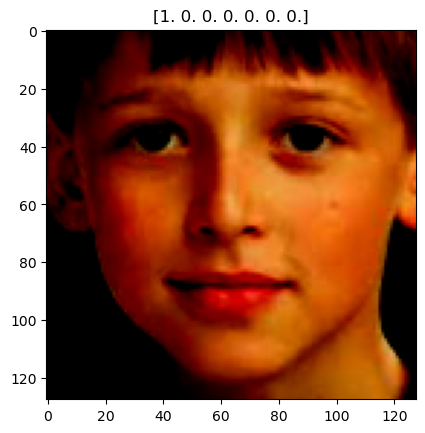

In [13]:
for image, label in train_ds.take(1):
    plt.imshow(image)
    plt.title(label.numpy())

In [14]:
batch_size = 4
buffer_size = 4000

In [15]:
train_ds = train_ds.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Building the individual networks if the GAN

In [16]:
def build_encoder():

    """
    Encoder Network
    """

    input_layer = keras.Input(shape = (128, 128, 3))

    ## 1st Convolutional Block
    enc = layers.Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = 'same')(input_layer) # (batch_size, 64, 64, 64)
    #enc = layers.BatchNormalization()(enc)
    enc = layers.ReLU()(enc)

    ## 2nd Convolutional Block
    enc = layers.Conv2D(filters = 128, kernel_size = 5, strides = 2, padding = 'same')(enc) # (batch_size, 32, 32, 128)
    #enc = layers.BatchNormalization()(enc)
    enc = layers.ReLU()(enc)

    ## 3rd Convolutional Block
    enc = layers.Conv2D(filters = 256, kernel_size = 5, strides = 2, padding = 'same')(enc) # (batch_size, 16, 16, 256)
    #enc = layers.BatchNormalization()(enc)
    enc = layers.ReLU()(enc)

    ## 4th Convolutional Block
    enc = layers.Conv2D(filters = 512, kernel_size = 5, strides = 2, padding = 'same')(enc) # (batch_size, 8, 8, 512)
    #enc = layers.BatchNormalization()(enc)
    enc = layers.ReLU()(enc)


    ## Flatten layer
    enc = layers.Flatten()(enc) # (batch_size, 8*8*512)

    ## 1st Fully Connected Layer
    enc = layers.Dense(50)(enc) # (batch_size, 50)
    #enc = layers.BatchNormalization()(enc)
    enc = layers.ReLU()(enc)

    ## 2nd Fully Connected Layer
    enc = layers.Dense(latent_dim)(enc)


    ## Create a model
    model = keras.Model(inputs = input_layer, outputs = enc)
    return model


In [17]:
def build_generator(num_classes=7):

    '''
    Generator Network
    '''
    latent_dims = latent_dim
    input_z_noise = keras.Input(shape = (latent_dims, ))
    input_label = keras.Input(shape = (num_classes, ))

    #init = keras.initializers.RandomNormal(stddev=0.02)
    #li = layers.Embedding(num_classes, 50)(input_label)
    #li = layers.Dense(12*12*1)(li)
    #li = layers.Reshape((12, 12, 1))(li)
    merge = layers.Concatenate()([input_z_noise, input_label])

    nodes = 8*8*1024
    x = layers.Dense(nodes)(merge)
    #x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Reshape((8, 8, 1024))(x)
    x = layers.Dropout(0.2)(x)

    # 1st Deconvolution Block
    x = layers.Conv2DTranspose(filters = 512, kernel_size = 5, padding = 'same', strides=2)(x) # (batch_size, 16, 16, 512)
    #x = layers.BatchNormalization(momentum = 0.8)(x)
    x = layers.ReLU()(x)

    # 2nd Deconvolution Block
    x = layers.Conv2DTranspose(filters = 256, kernel_size = 5, padding = 'same', strides=2)(x) # (batch_size, 32, 32, 256)
    #x = layers.BatchNormalization(momentum = 0.8)(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)

    # 3rd Deconvolution Block
    x = layers.Conv2DTranspose(filters = 128, kernel_size = 5, padding = 'same', strides=2)(x) # (batch_size, 32, 32, 128)
    #x = layers.BatchNormalization(momentum = 0.8)(x)
    x = layers.ReLU()(x)

    # 4th Deconvolution Block
    x = layers.Conv2DTranspose(filters = 64, kernel_size = 5, padding = 'same', strides=2)(x) # (batch_size, 64, 64, 64)
    #x = layers.BatchNormalization(momentum = 0.8)(x)
    x = layers.ReLU()(x)



    dec = layers.Conv2DTranspose(filters = 3, kernel_size = 5, padding = 'same', strides=1, activation='tanh')(x) # (batch_size, 128, 128, 3)

    model = keras.Model(inputs = [input_z_noise, input_label], outputs = dec)
    return model


In [18]:
def expand_label_input(x):
    x = K.expand_dims(x, axis = 1)
    x = K.expand_dims(x, axis = 1)
    x = K.tile(x, [1, 64, 64, 1])
    return x


In [19]:
# loss function
def l2_norm(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred)))

In [20]:
def build_discriminator(num_classes=7):

    """
    Discriminator Network
    """

    input_shape = (128, 128, 3)
    label_shape = (num_classes, )
    image_input = keras.Input(shape = input_shape)
    label_input = keras.Input(shape = label_shape)

    #init = keras.initializers.RandomNormal(stddev=0.02)
    #const = ClipConstraint(0.01)

    #li = layers.Embedding(num_classes, 50)(label_input)
    #li = layers.Dense(48*48*1, activation='relu')(li)
    #li = layers.Reshape((48, 48, 1))(li)


    # 1st Convolution Block
    x = layers.Conv2D(16, kernel_size = 5, strides = 2, padding = 'same')(image_input) # (batch_size, 64, 64, 16)
    #x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    li = layers.Lambda(expand_label_input)(label_input)
    x = layers.Concatenate()([x, li]) # (batch_size, 16, 16, n+16)

   # 2nd Convolution Block
    x = layers.Conv2D(32, kernel_size = 5, strides=(2, 2), padding='same')(x) # (batch_size, 32, 32, 32)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    # 3rd Convolution Block
    x = layers.Conv2D(64, kernel_size = 5, strides=(2, 2), padding='same')(x) # (batch_size, 16, 16, 64)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    # 4th Convolution Block
    x = layers.Conv2D(128, kernel_size = 5, strides=(2, 2), padding='same')(x) # (batch_size, 8, 8, 128)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(1, activation='sigmoid')(x)
    #x = layers.Conv2D(1, kernel_size = 5, strides = 1, activation = 'sigmoid')(x)
    model = keras.Model(inputs = [image_input, label_input], outputs = x)
    return model


In [21]:
discriminator = build_discriminator()
generator = build_generator()
encoder = build_encoder()

# GAN model

In [23]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, encoder):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.encoder = encoder



    def compile(self, d_optimizer, g_optimizer, loss_fn, loss_fn2):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.loss_fn2 = loss_fn2

    def discriminator_loss(self, real, fake):
        real_loss = self.loss_fn(tf.ones_like(real), real)
        fake_loss = self.loss_fn(tf.zeros_like(fake), fake)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake):
        fake_loss = self.loss_fn(tf.ones_like(fake), fake)
        return fake_loss

    def train_step(self, batch):
        tr_image, tr_label = batch

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:


            enc = self.encoder(tr_image)
            generated_image = self.generator([enc, tr_label], training=True)

            real = self.discriminator([tr_image, tr_label], training=True)
            fake = self.discriminator([generated_image, tr_label], training=True)

            gen_loss = self.generator_loss(fake)

            l2_norm = self.loss_fn2(generated_image, tr_image)
            disc_loss = self.discriminator_loss(real, fake)

            total_loss = 100 * l2_norm + gen_loss
        gen_grad = gen_tape.gradient(total_loss, self.generator.trainable_variables)
        disc_grad = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)


        self.g_optimizer.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(disc_grad, self.discriminator.trainable_variables))

        return {"disc_loss": disc_loss, "gen_loss":gen_loss, "l2_loss": l2_norm, "total_loss":total_loss}



In [24]:
cGAN = GAN(discriminator=discriminator, generator=generator, encoder=encoder)

In [25]:
cGAN.compile(g_optimizer=keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999, epsilon = 10e-8),
             d_optimizer=keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999, epsilon = 10e-8),
             loss_fn=keras.losses.BinaryCrossentropy(),
             loss_fn2=l2_norm)

In [26]:
epochs = 50
for image, label in train_ds.take(1):
    seed = image[0:4, :, :, :]
    labels = label[0:4, :]

In [22]:
path = '/content/drive/My Drive/colab_notebooks/AGEGAN_IMAGES/'

# Callback to monitor images
class Generate(keras.callbacks.Callback):
    def __init__(self):
        super(Generate, self).__init__()
        self.encoded = encoder(seed)
        
    def on_epoch_end(self, epoch, logs=None):
        prediction = generator([self.encoded, labels])

        plt.figure(figsize=(16, 16))
        for i in range(4):
            plt.subplot(2, 2, i+1)
            plt.imshow(prediction[i])
            plt.axis('off')

        plt.savefig(f'{path}/image at epoch {epoch+1}.png')

#save model weights after every epoch incase of interuption
class Checkpoint_callback(keras.callbacks.Callback):
    def __init__(self):
        super(Checkpoint_callback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        encoder.save('encoder.h5')
        generator.save('generator.h5')
        discriminator.save('discriminator.h5')

Epoch 1/50
4321/4321 [==============================] - ETA: 0s - disc_loss: 0.8006 - gen_loss: 2.5358 - l2_loss: 0.3672 - total_loss: 39.2564

4321/4321 [==============================] - 276s 61ms/step - disc_loss: 0.8007 - gen_loss: 2.5364 - l2_loss: 0.3672 - total_loss: 39.2567
Epoch 2/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7661 - gen_loss: 2.2906 - l2_loss: 0.3416 - total_loss: 36.4534

4321/4321 [==============================] - 266s 61ms/step - disc_loss: 0.7659 - gen_loss: 2.2908 - l2_loss: 0.3416 - total_loss: 36.4515
Epoch 3/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7723 - gen_loss: 2.2347 - l2_loss: 0.3348 - total_loss: 35.7168

4321/4321 [==============================] - 263s 60ms/step - disc_loss: 0.7737 - gen_loss: 2.2358 - l2_loss: 0.3348 - total_loss: 35.7147
Epoch 4/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7482 - gen_loss: 2.2497 - l2_loss: 0.3308 - total_loss: 35.3287

4321/4321 [==============================] - 263s 61ms/step - disc_loss: 0.7479 - gen_loss: 2.2495 - l2_loss: 0.3308 - total_loss: 35.3309
Epoch 5/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7361 - gen_loss: 2.2505 - l2_loss: 0.3284 - total_loss: 35.0872

4321/4321 [==============================] - 263s 61ms/step - disc_loss: 0.7364 - gen_loss: 2.2496 - l2_loss: 0.3284 - total_loss: 35.0859
Epoch 6/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7277 - gen_loss: 2.2448 - l2_loss: 0.3251 - total_loss: 34.7555

4321/4321 [==============================] - 262s 60ms/step - disc_loss: 0.7275 - gen_loss: 2.2457 - l2_loss: 0.3251 - total_loss: 34.7564
Epoch 7/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7160 - gen_loss: 2.2627 - l2_loss: 0.3233 - total_loss: 34.5881

4321/4321 [==============================] - 262s 60ms/step - disc_loss: 0.7157 - gen_loss: 2.2636 - l2_loss: 0.3233 - total_loss: 34.5887
Epoch 8/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7117 - gen_loss: 2.2732 - l2_loss: 0.3210 - total_loss: 34.3768

4321/4321 [==============================] - 264s 60ms/step - disc_loss: 0.7115 - gen_loss: 2.2732 - l2_loss: 0.3211 - total_loss: 34.3844
Epoch 9/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7016 - gen_loss: 2.2936 - l2_loss: 0.3194 - total_loss: 34.2371

4321/4321 [==============================] - 264s 61ms/step - disc_loss: 0.7013 - gen_loss: 2.2937 - l2_loss: 0.3194 - total_loss: 34.2355
Epoch 10/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7005 - gen_loss: 2.2782 - l2_loss: 0.3179 - total_loss: 34.0681

4321/4321 [==============================] - 263s 61ms/step - disc_loss: 0.7005 - gen_loss: 2.2786 - l2_loss: 0.3179 - total_loss: 34.0687
Epoch 11/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7080 - gen_loss: 2.2666 - l2_loss: 0.3163 - total_loss: 33.8922

4321/4321 [==============================] - 265s 61ms/step - disc_loss: 0.7099 - gen_loss: 2.2675 - l2_loss: 0.3162 - total_loss: 33.8883
Epoch 12/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.6975 - gen_loss: 2.2643 - l2_loss: 0.3144 - total_loss: 33.7064

4321/4321 [==============================] - 262s 60ms/step - disc_loss: 0.6973 - gen_loss: 2.2641 - l2_loss: 0.3144 - total_loss: 33.7067
Epoch 13/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7040 - gen_loss: 2.2362 - l2_loss: 0.3128 - total_loss: 33.5208

4321/4321 [==============================] - 264s 61ms/step - disc_loss: 0.7037 - gen_loss: 2.2362 - l2_loss: 0.3128 - total_loss: 33.5207
Epoch 14/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7080 - gen_loss: 2.2501 - l2_loss: 0.3113 - total_loss: 33.3839

4321/4321 [==============================] - 265s 61ms/step - disc_loss: 0.7077 - gen_loss: 2.2501 - l2_loss: 0.3114 - total_loss: 33.3854
Epoch 15/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.6977 - gen_loss: 2.2538 - l2_loss: 0.3096 - total_loss: 33.2113

4321/4321 [==============================] - 263s 61ms/step - disc_loss: 0.6987 - gen_loss: 2.2552 - l2_loss: 0.3095 - total_loss: 33.2091
Epoch 16/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7047 - gen_loss: 2.2470 - l2_loss: 0.3087 - total_loss: 33.1166

4321/4321 [==============================] - 263s 60ms/step - disc_loss: 0.7046 - gen_loss: 2.2466 - l2_loss: 0.3087 - total_loss: 33.1166
Epoch 17/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7180 - gen_loss: 2.2068 - l2_loss: 0.3072 - total_loss: 32.9227

4321/4321 [==============================] - 262s 60ms/step - disc_loss: 0.7179 - gen_loss: 2.2076 - l2_loss: 0.3072 - total_loss: 32.9240
Epoch 18/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7119 - gen_loss: 2.2488 - l2_loss: 0.3055 - total_loss: 32.7997

4321/4321 [==============================] - 262s 60ms/step - disc_loss: 0.7130 - gen_loss: 2.2490 - l2_loss: 0.3055 - total_loss: 32.7973
Epoch 19/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7044 - gen_loss: 2.2307 - l2_loss: 0.3034 - total_loss: 32.5722

4321/4321 [==============================] - 260s 60ms/step - disc_loss: 0.7049 - gen_loss: 2.2310 - l2_loss: 0.3034 - total_loss: 32.5703
Epoch 20/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.7065 - gen_loss: 2.2220 - l2_loss: 0.3024 - total_loss: 32.4625

4321/4321 [==============================] - 262s 60ms/step - disc_loss: 0.7074 - gen_loss: 2.2221 - l2_loss: 0.3024 - total_loss: 32.4606
Epoch 21/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.6961 - gen_loss: 2.2305 - l2_loss: 0.3004 - total_loss: 32.2738

<ipython-input-30-df85e810769a>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16, 16))


4321/4321 [==============================] - 260s 60ms/step - disc_loss: 0.6974 - gen_loss: 2.2295 - l2_loss: 0.3004 - total_loss: 32.2702
Epoch 22/50
4320/4321 [============================>.] - ETA: 0s - disc_loss: 0.6961 - gen_loss: 2.2314 - l2_loss: 0.2987 - total_loss: 32.1048

4321/4321 [==============================] - 260s 60ms/step - disc_loss: 0.6958 - gen_loss: 2.2317 - l2_loss: 0.2987 - total_loss: 32.1057
Epoch 23/50
2733/4321 [=================>............] - ETA: 1:34 - disc_loss: 0.6915 - gen_loss: 2.2534 - l2_loss: 0.2989 - total_loss: 32.1456

KeyboardInterrupt: ignored

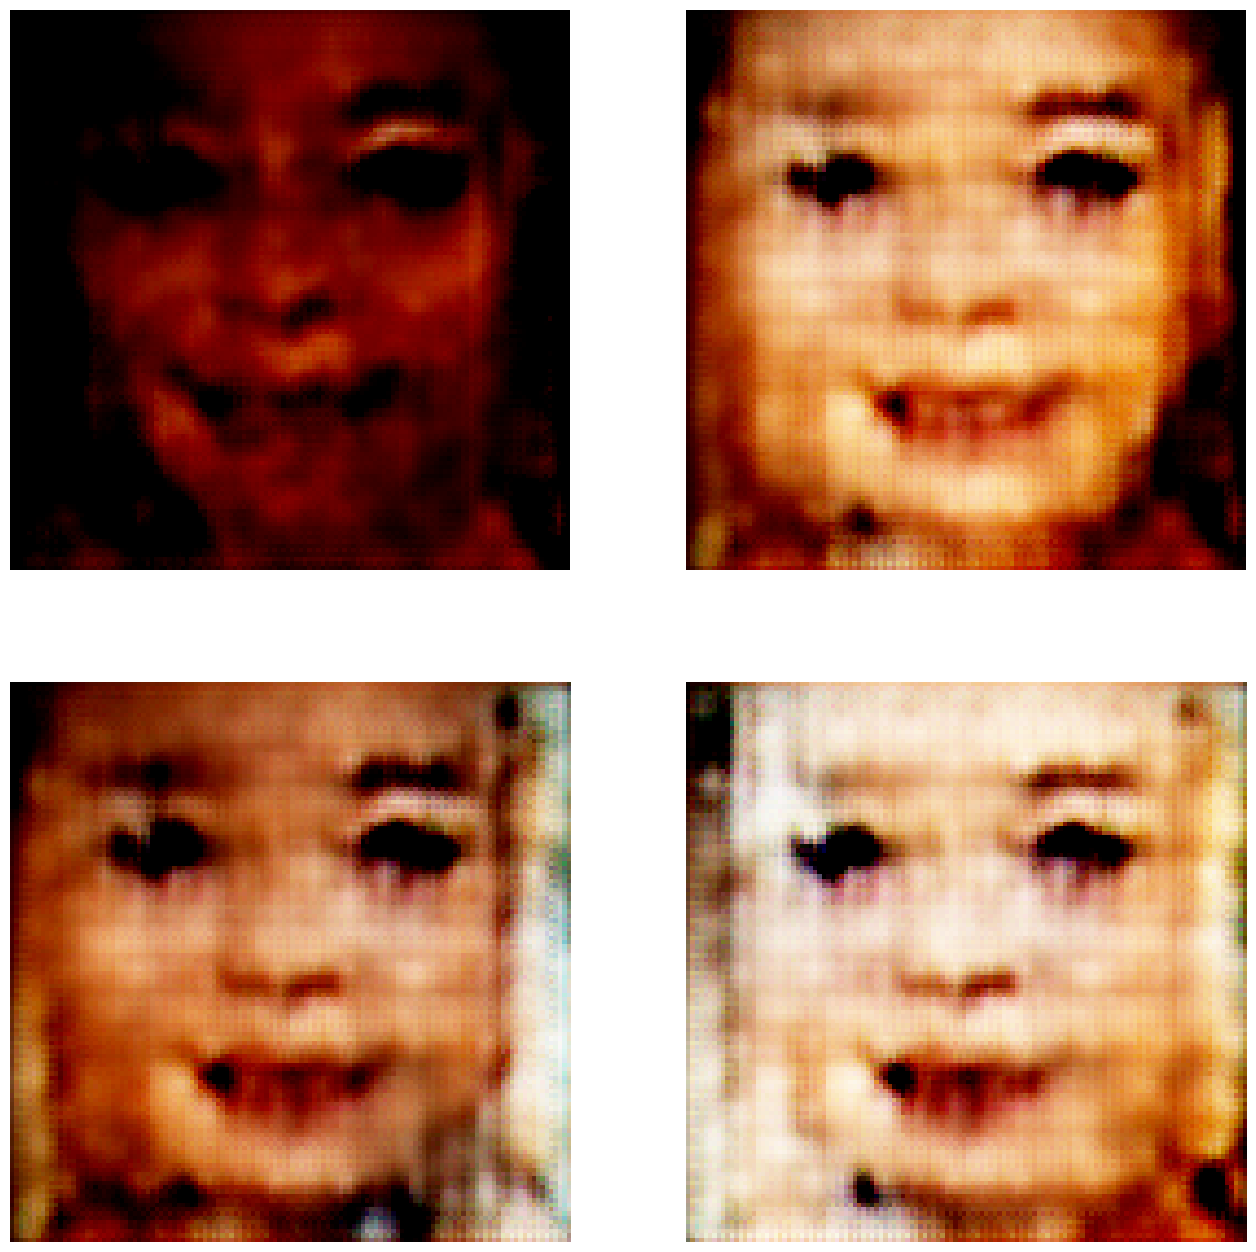

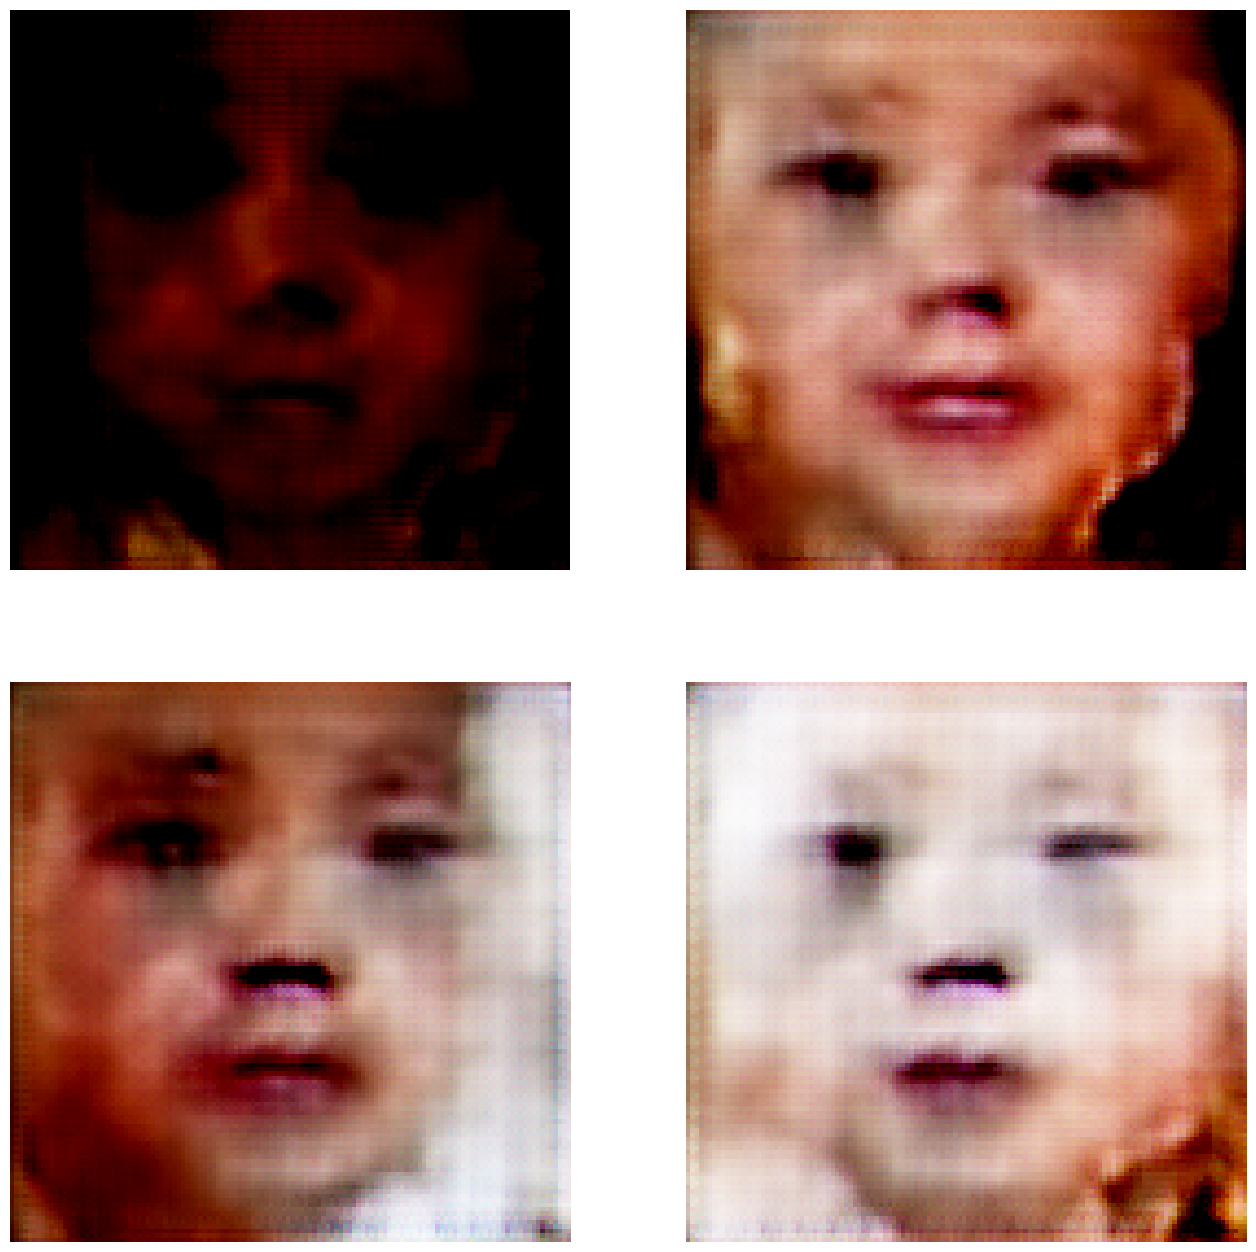

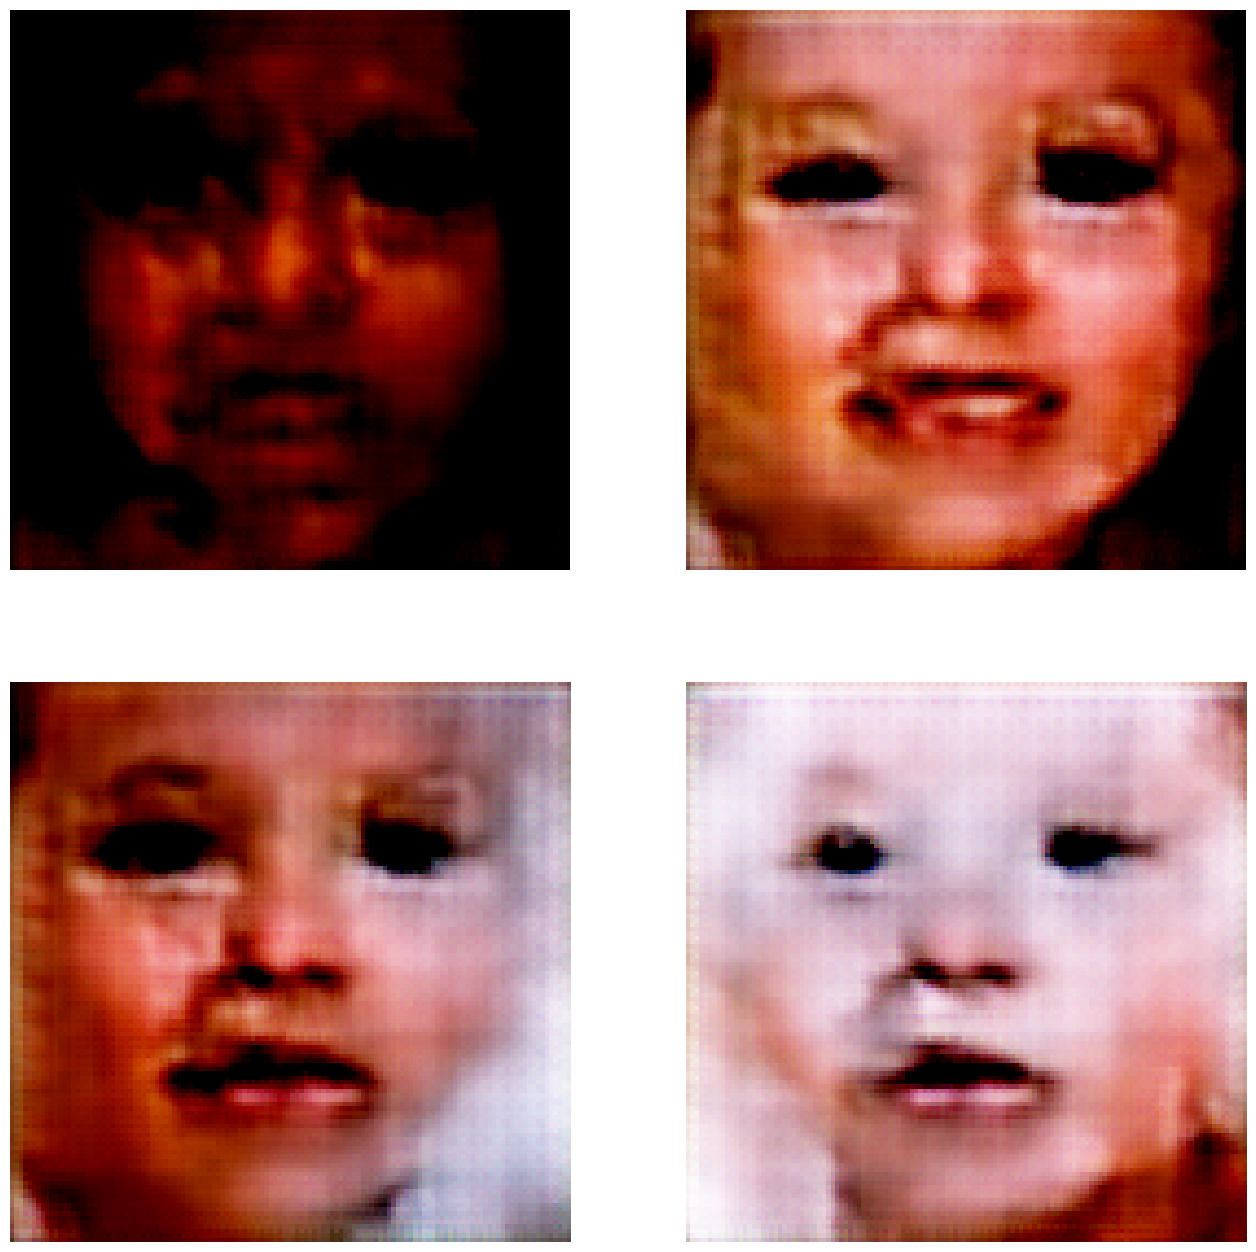

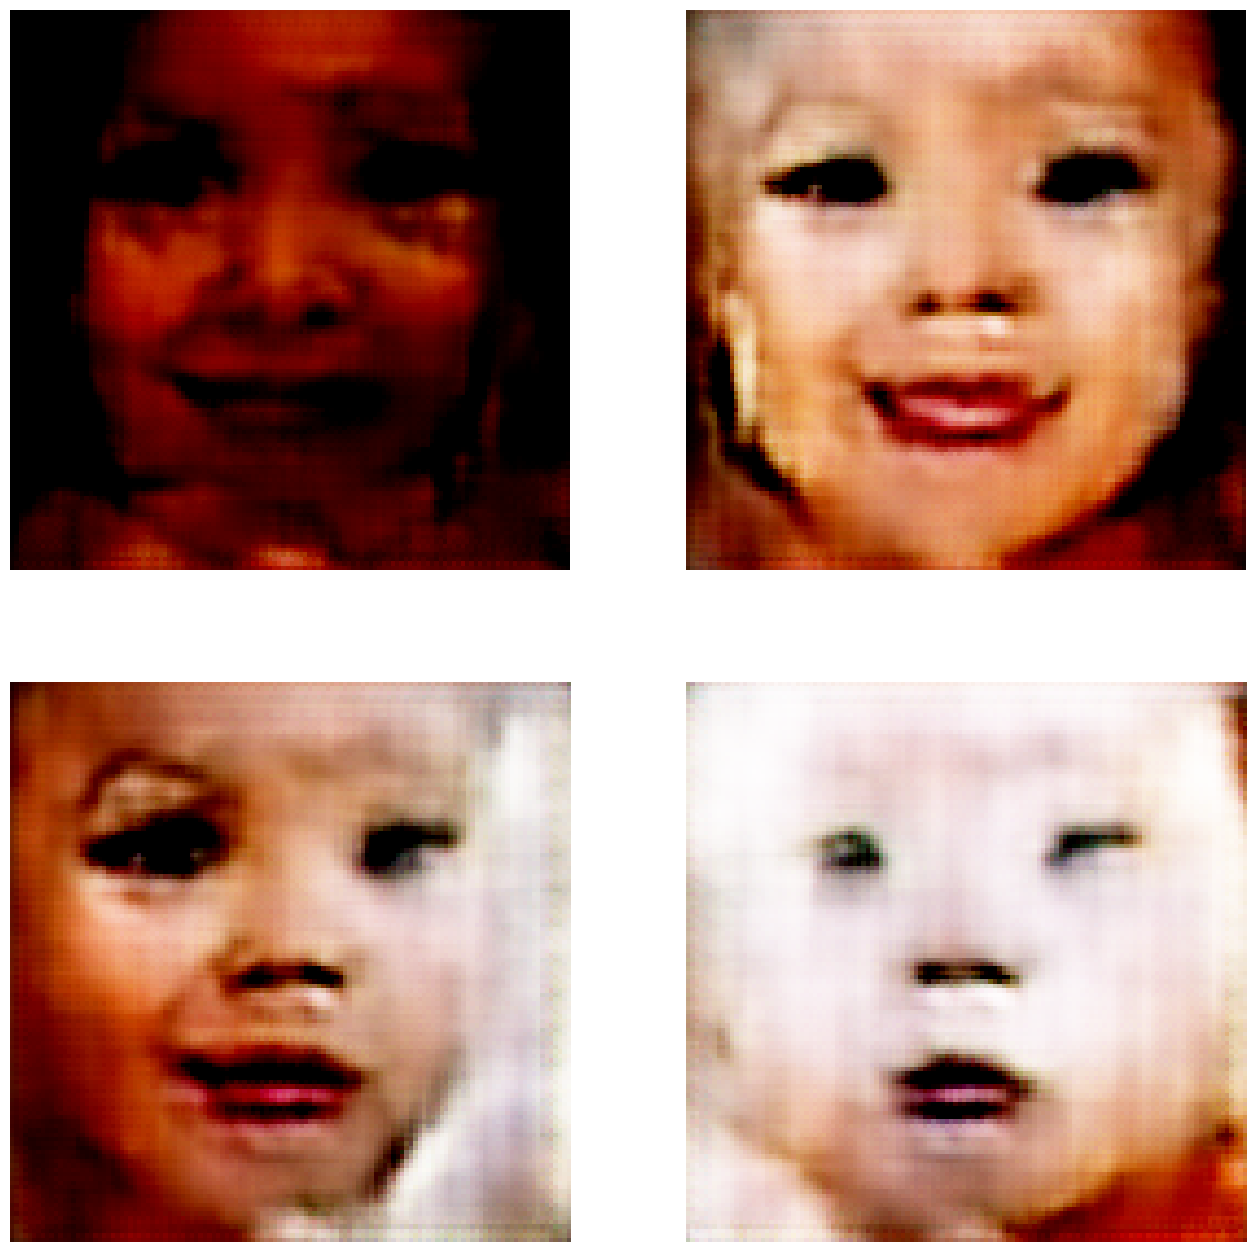

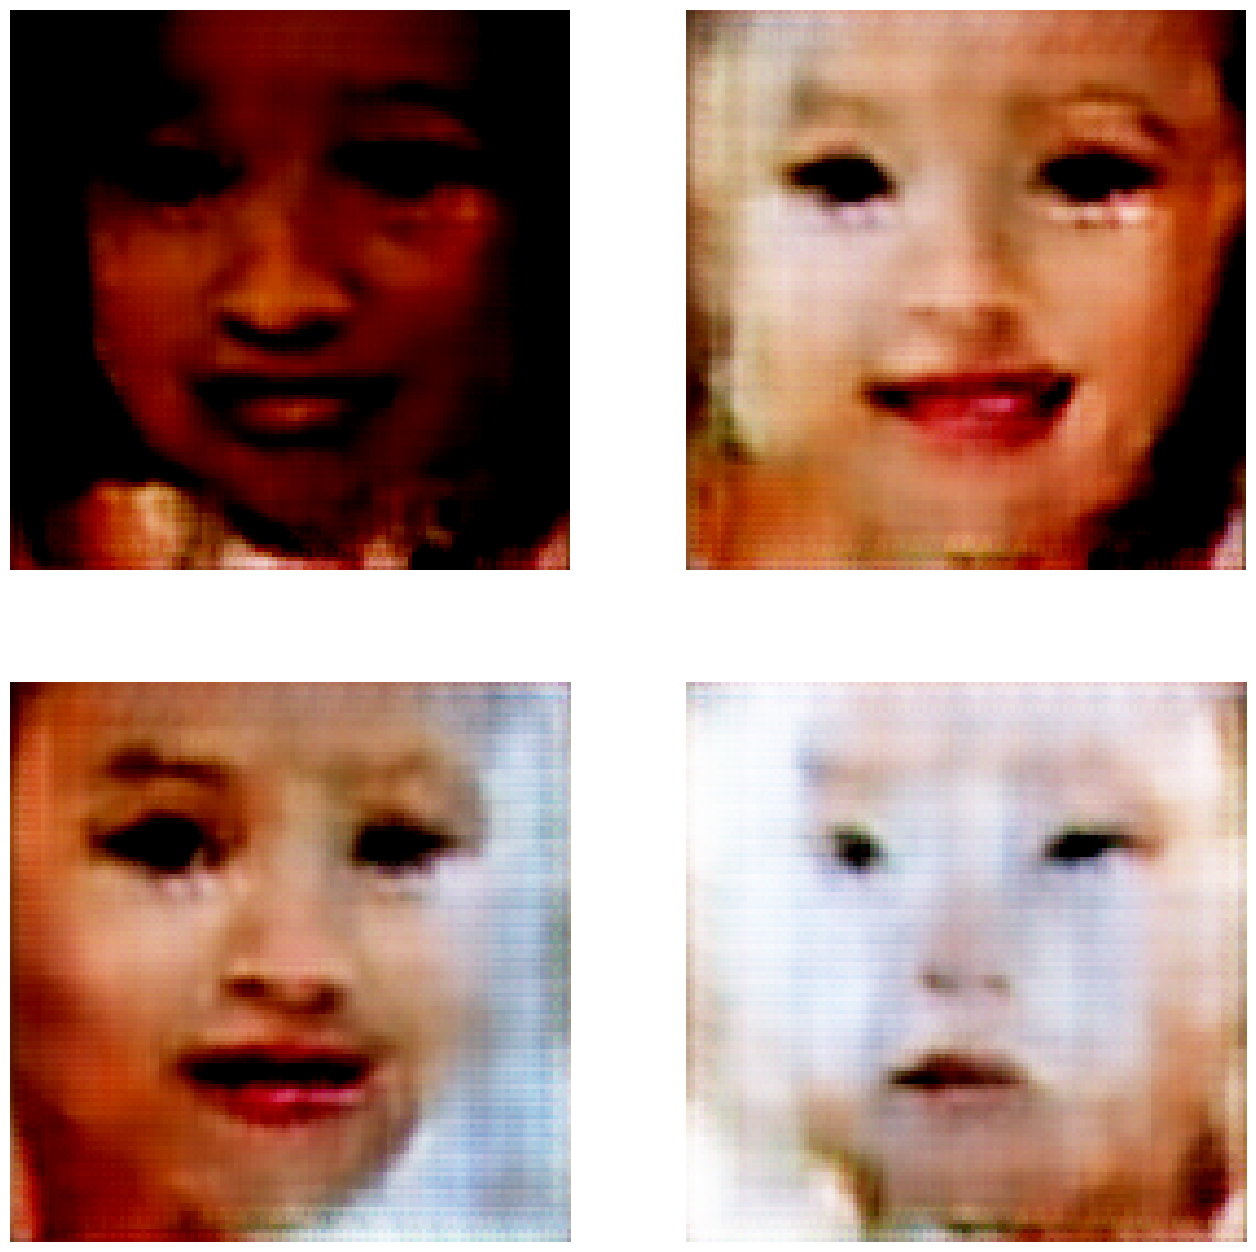

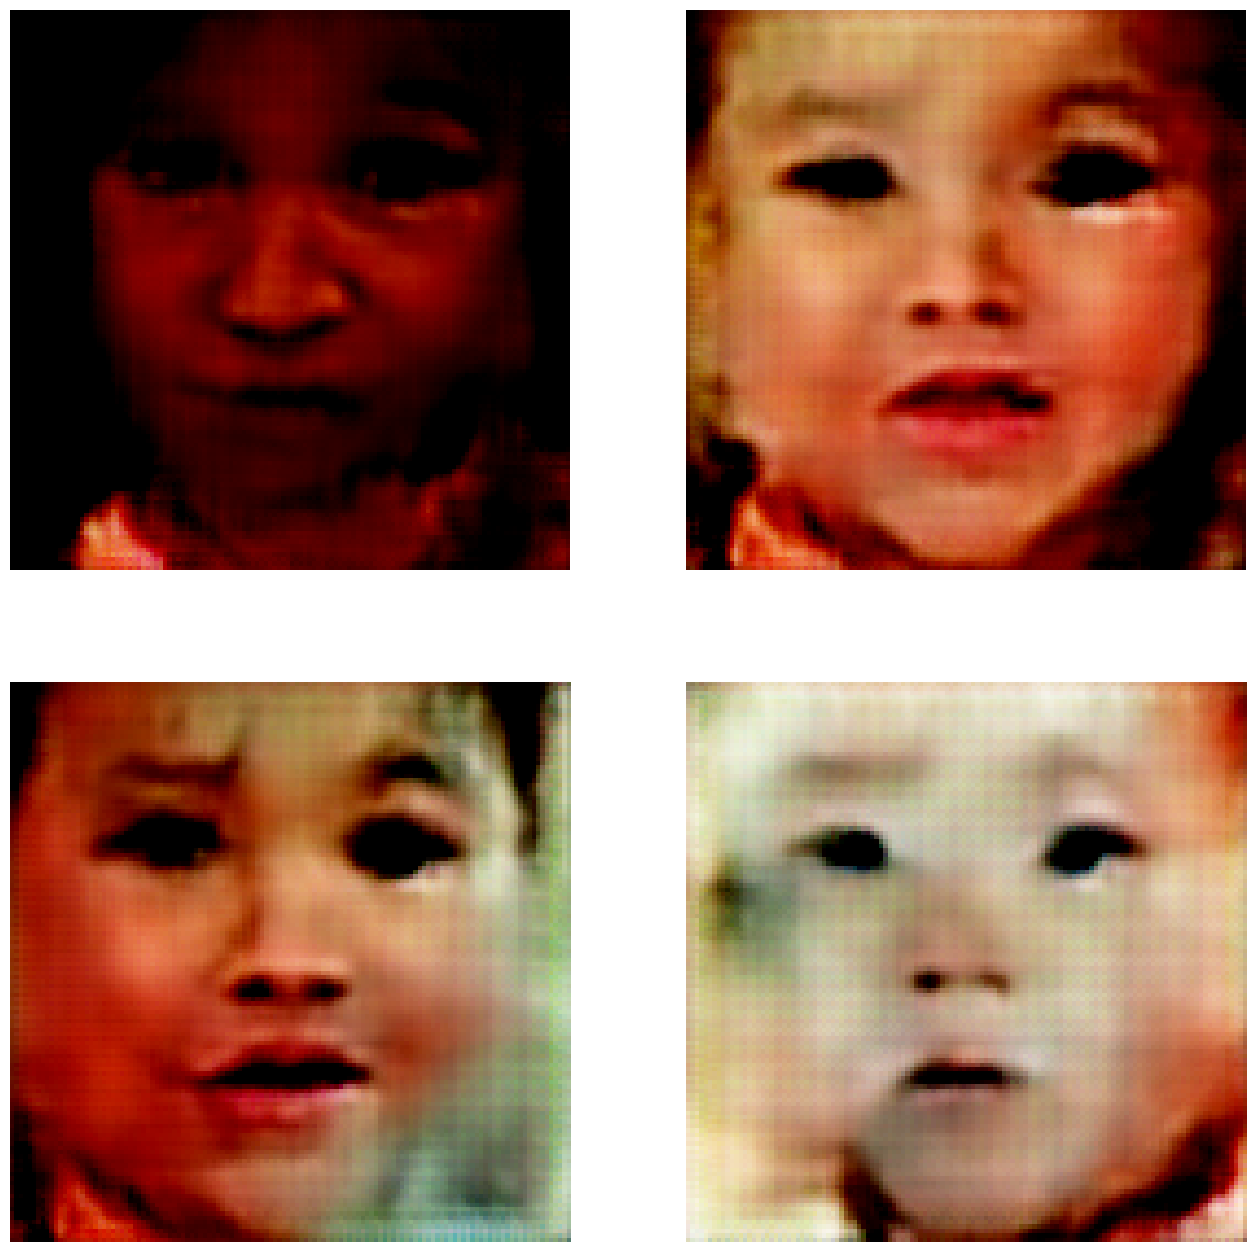

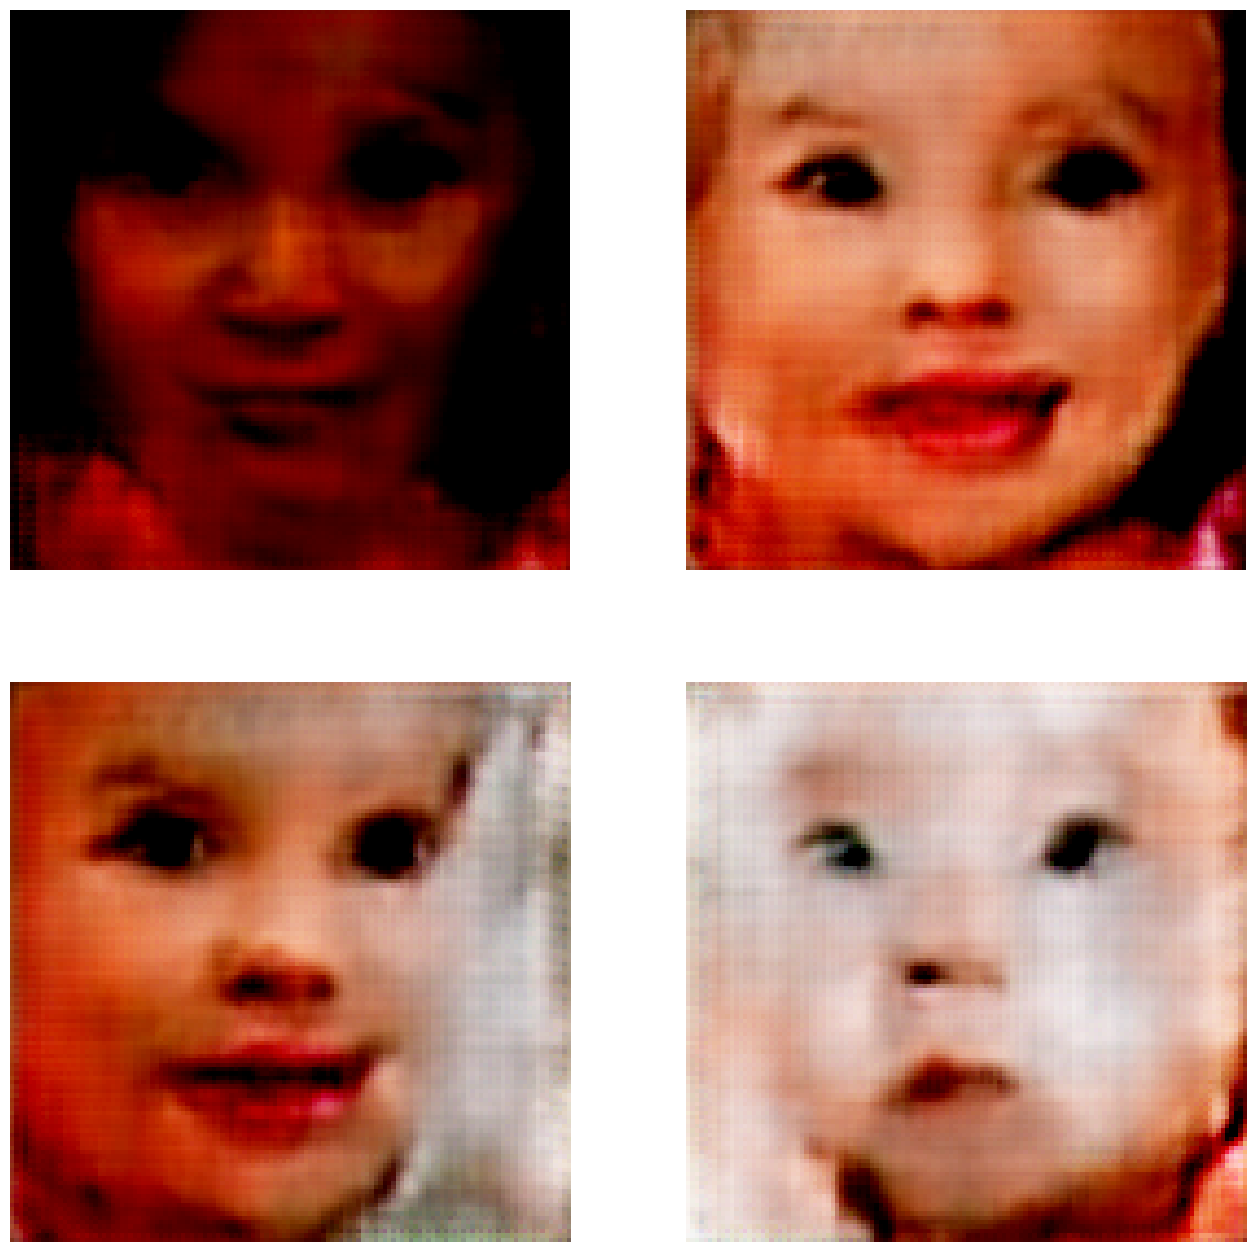

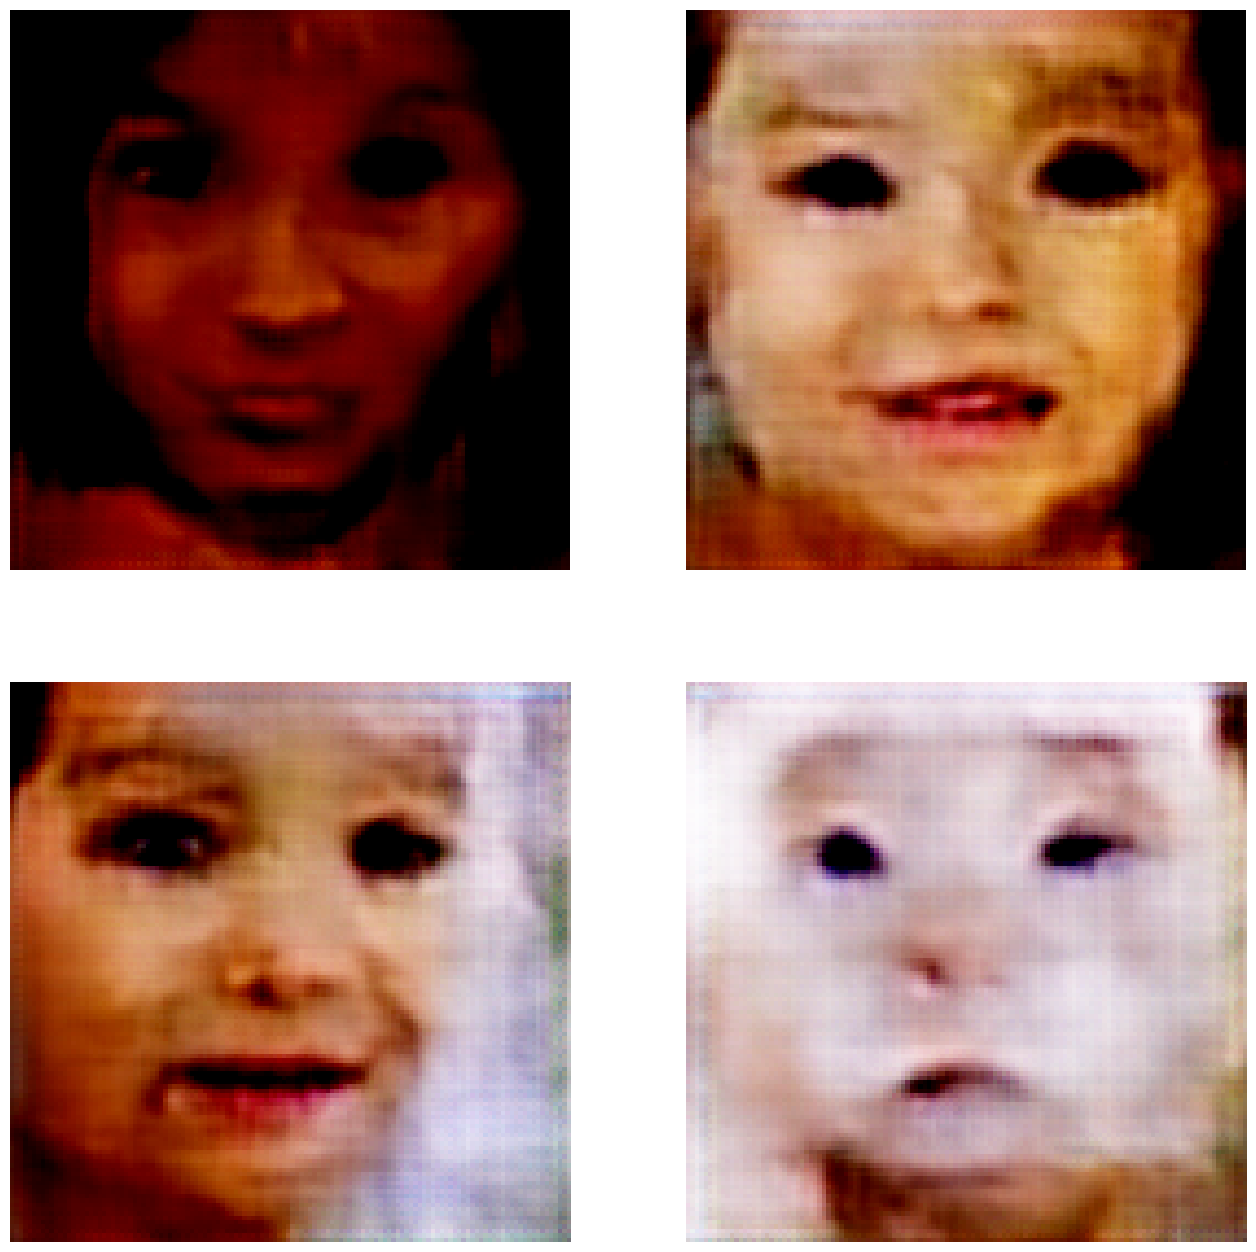

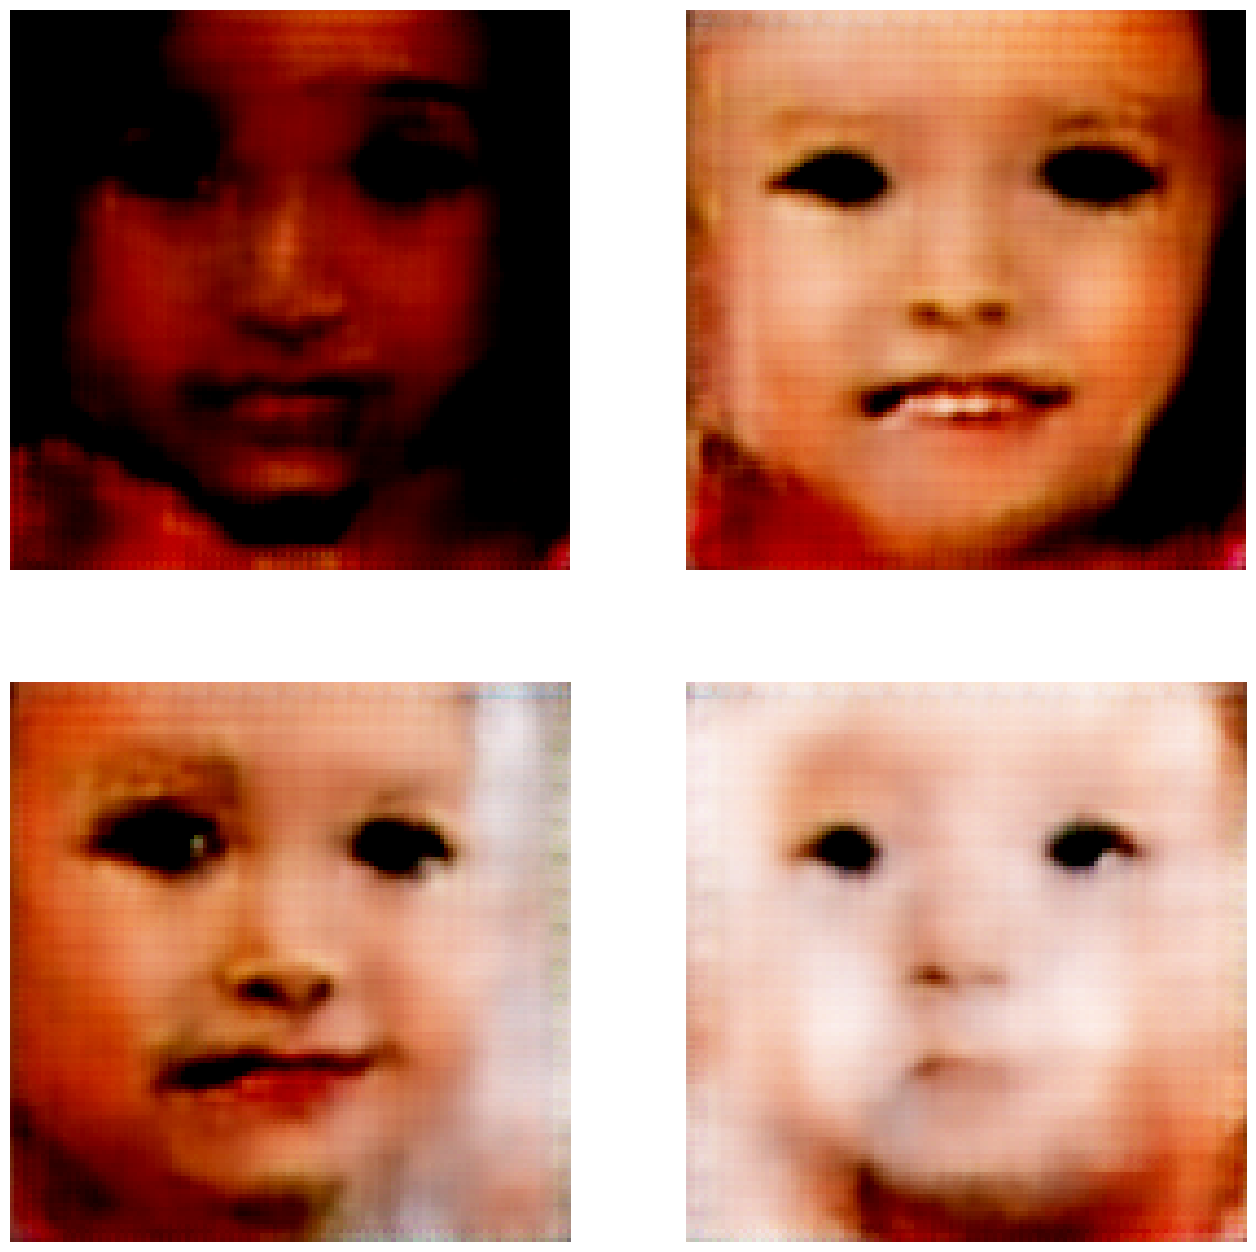

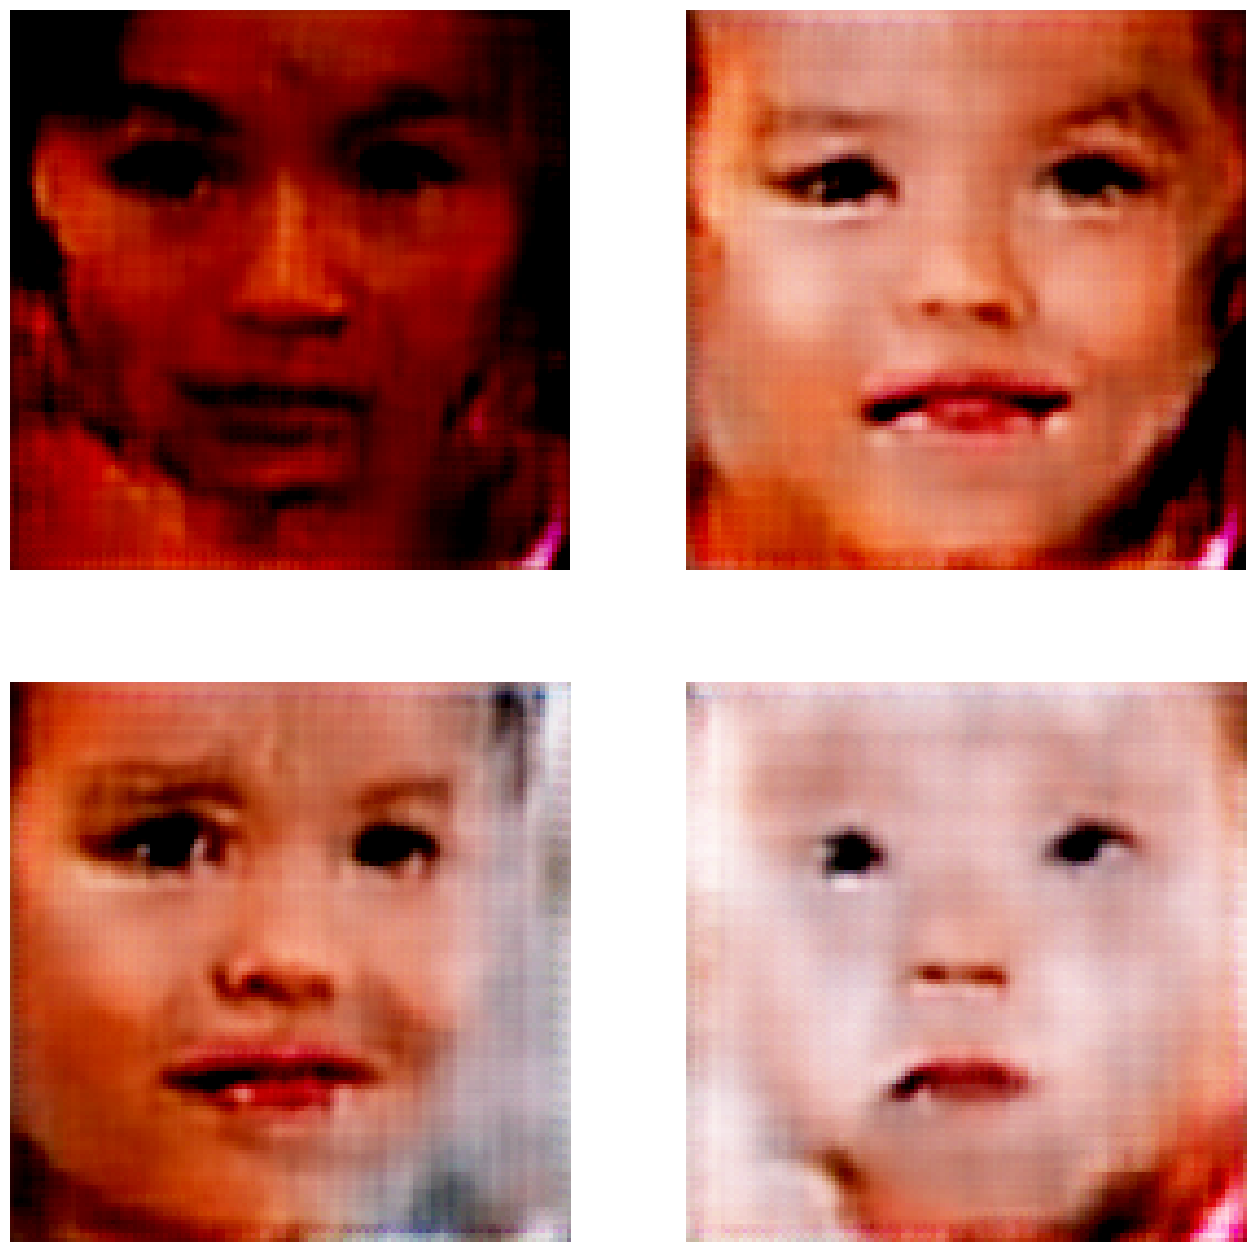

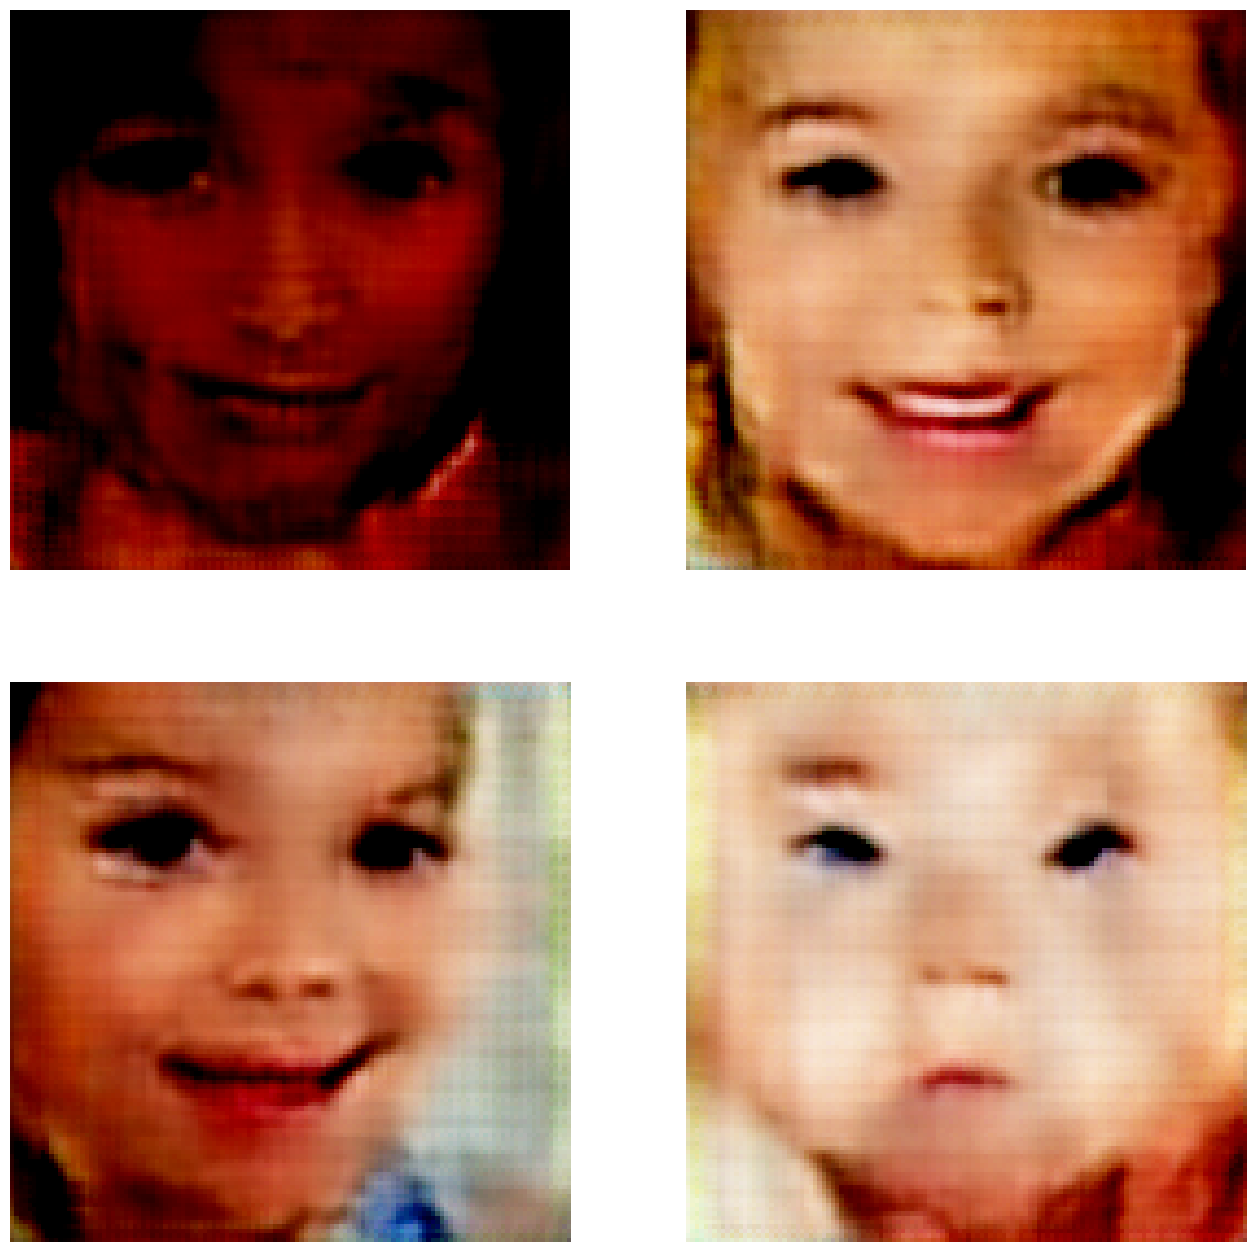

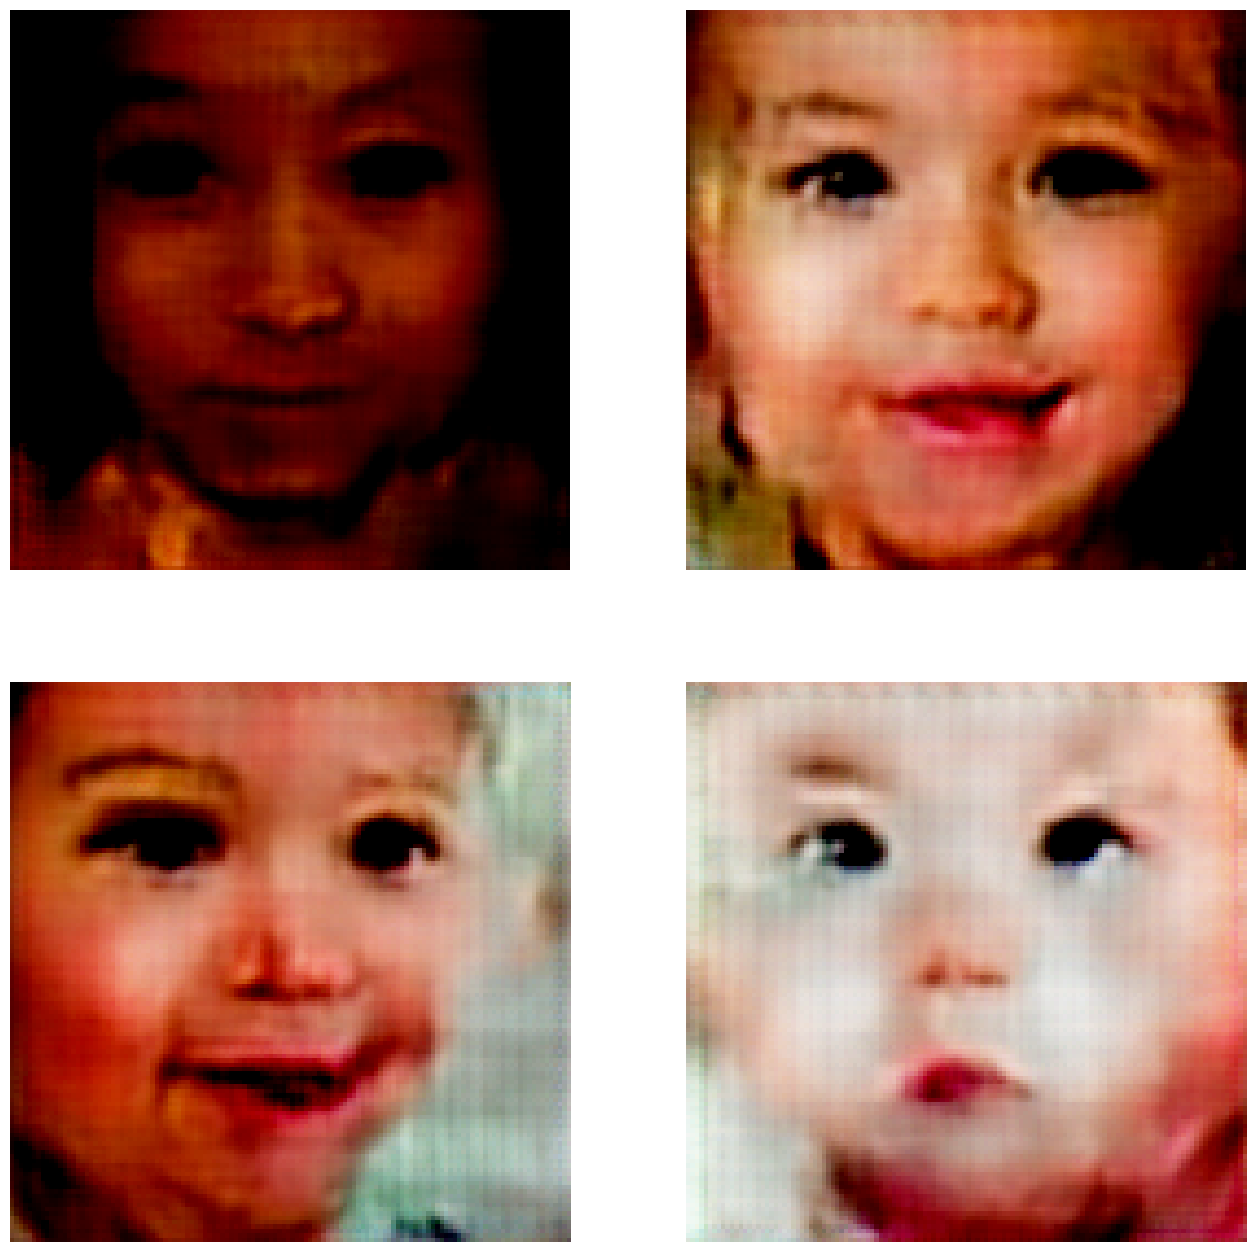

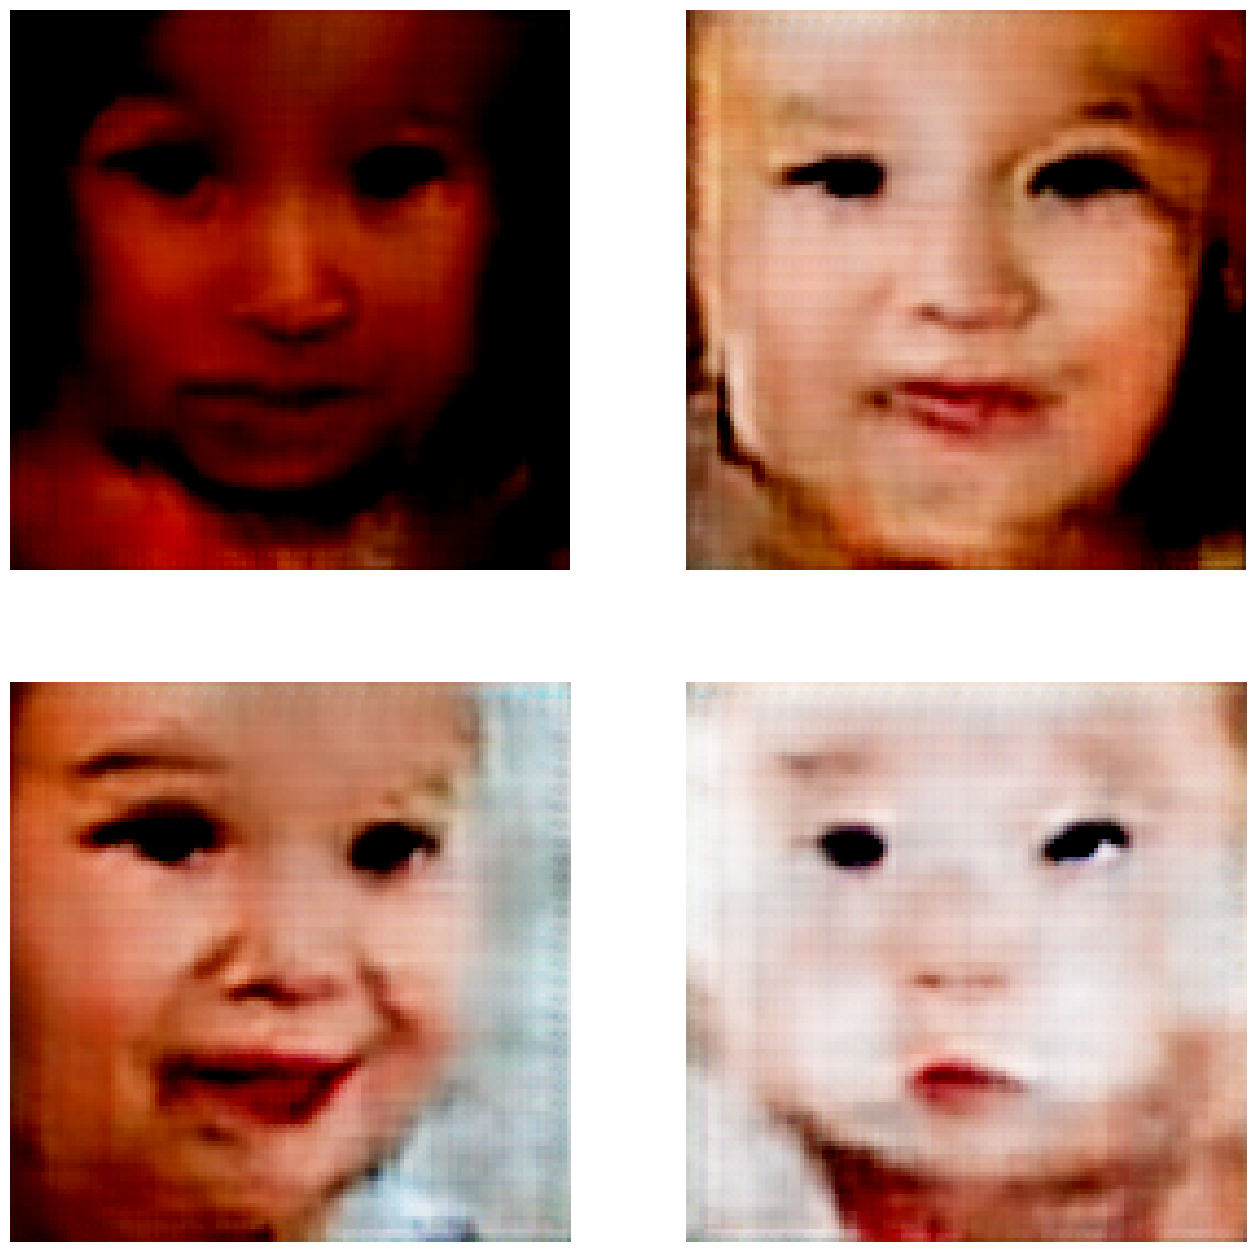

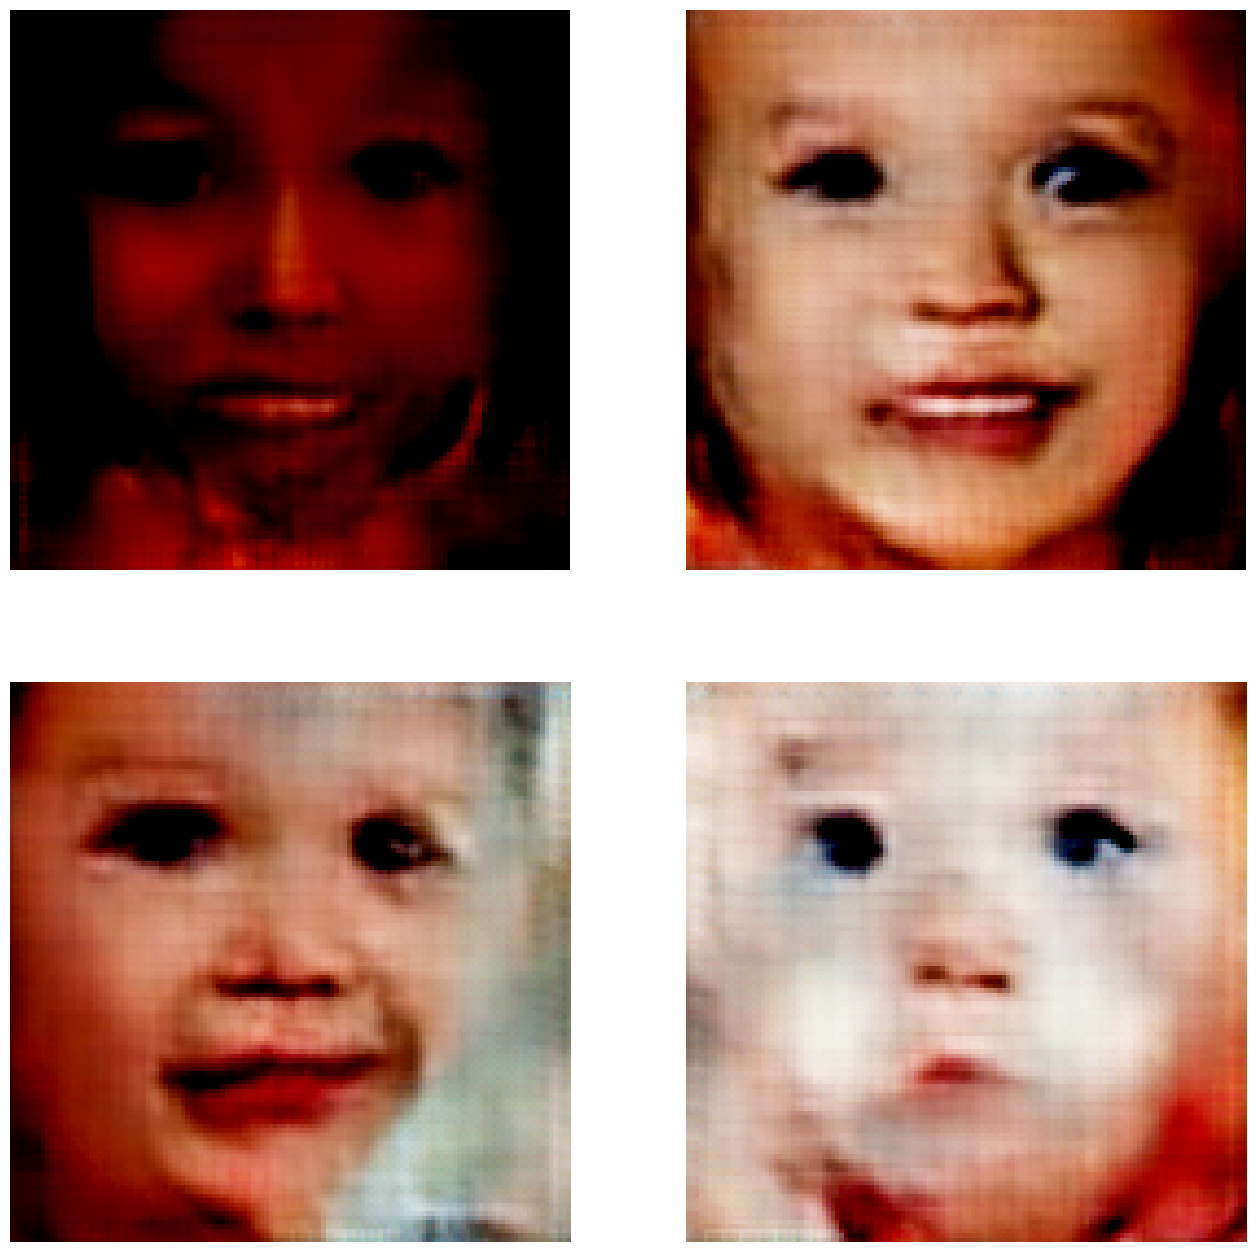

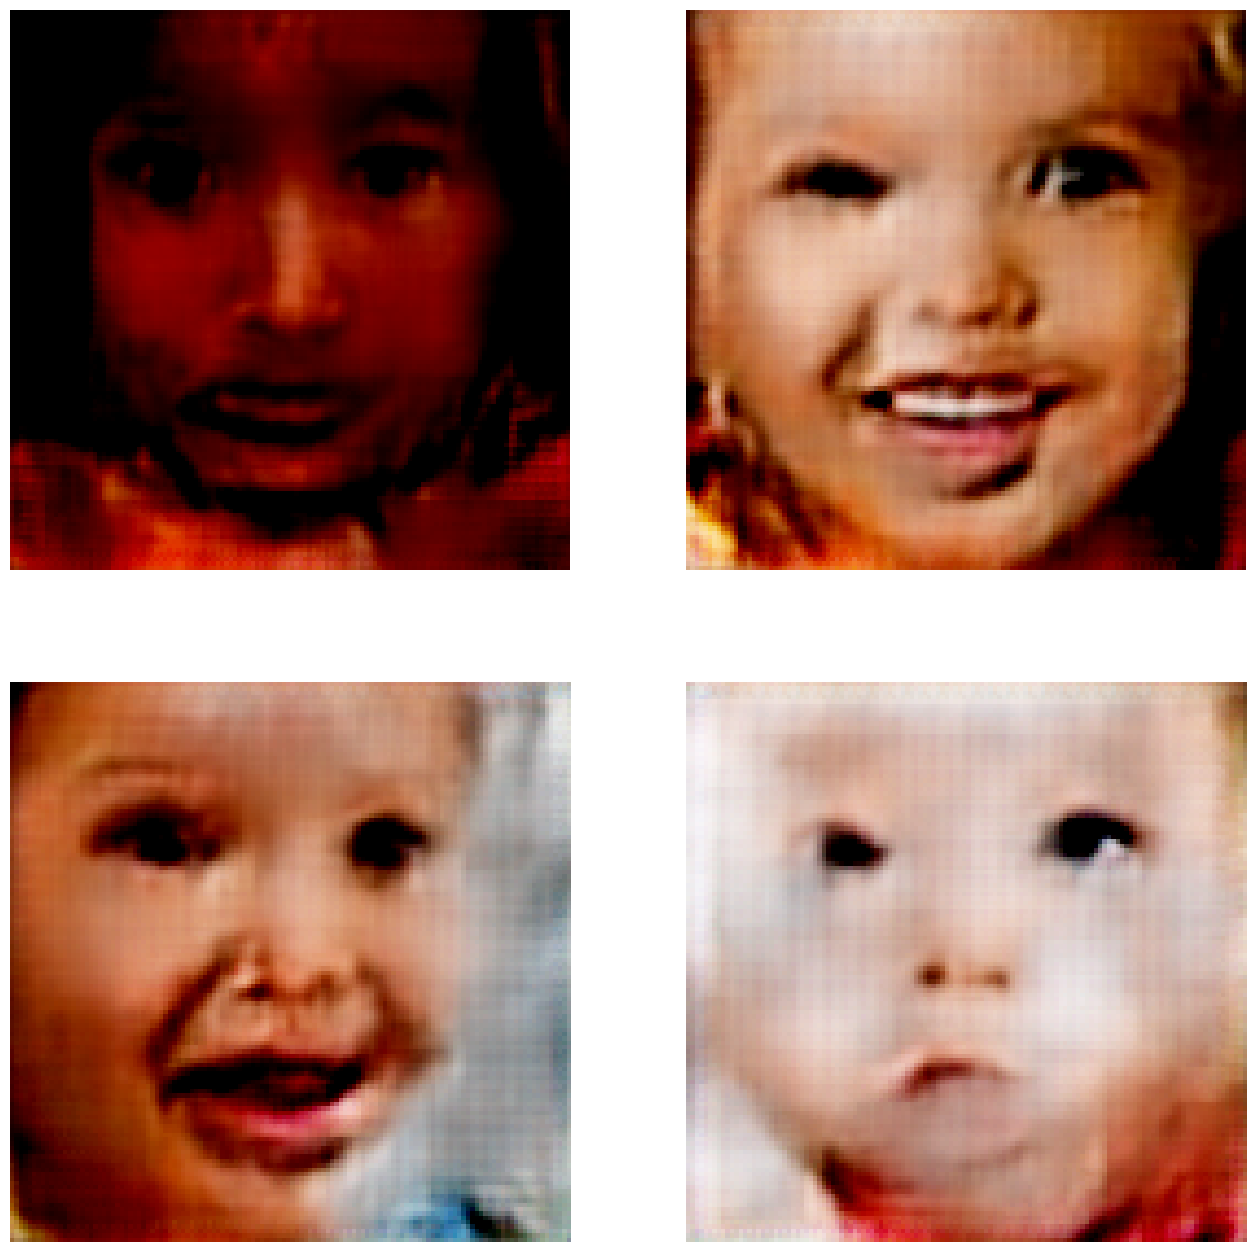

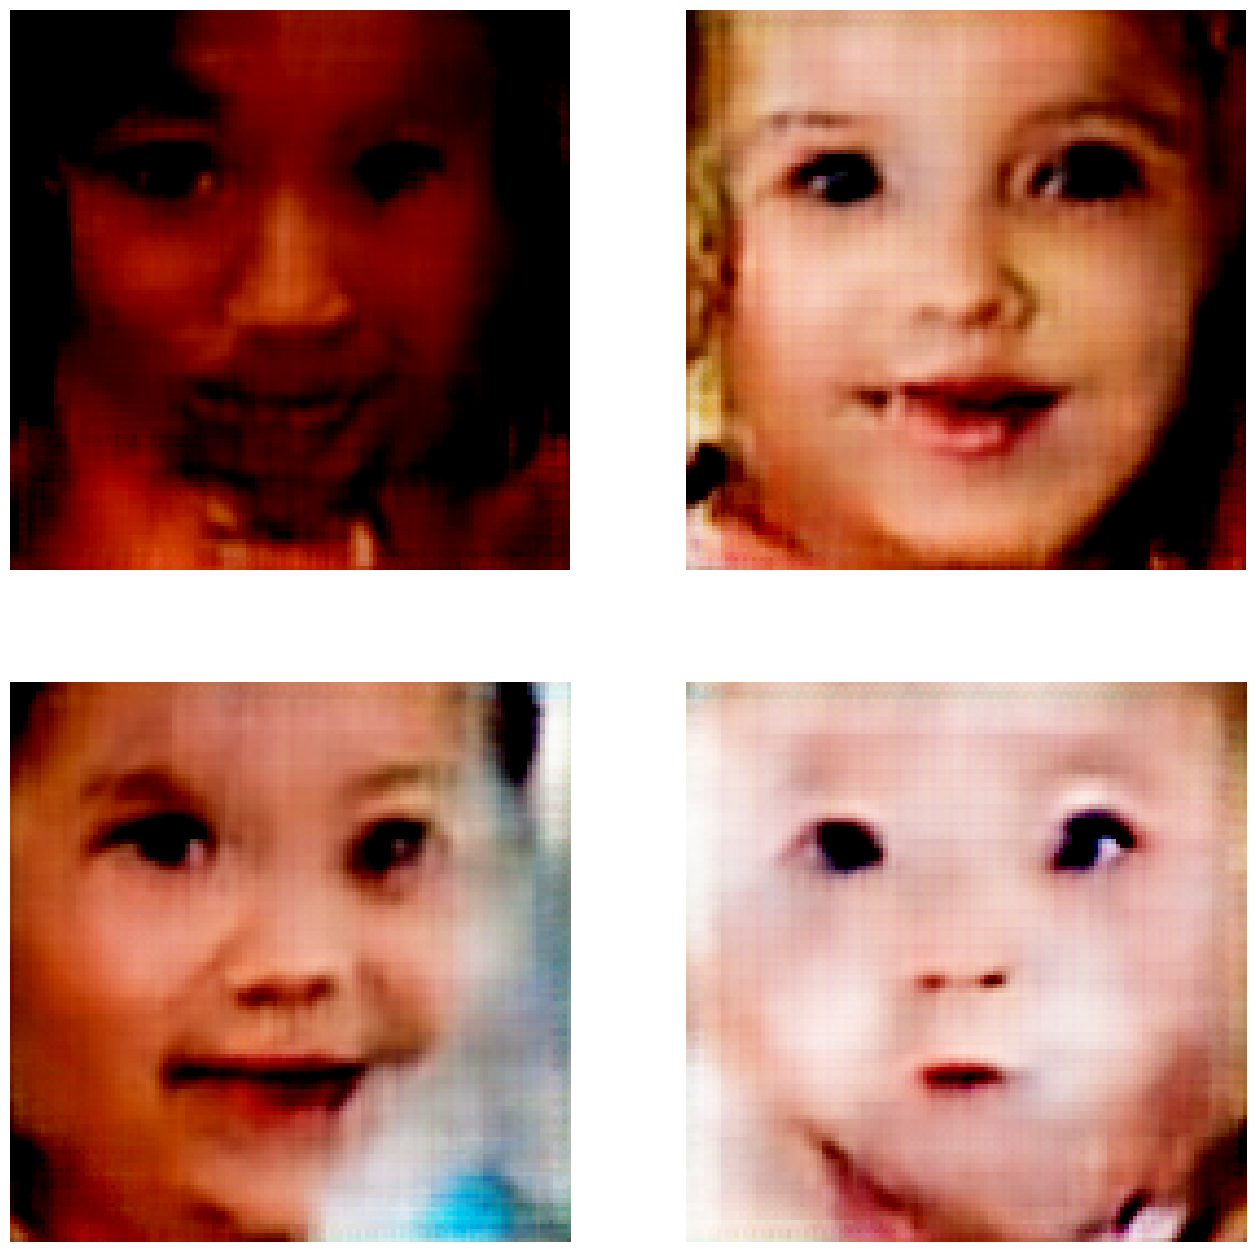

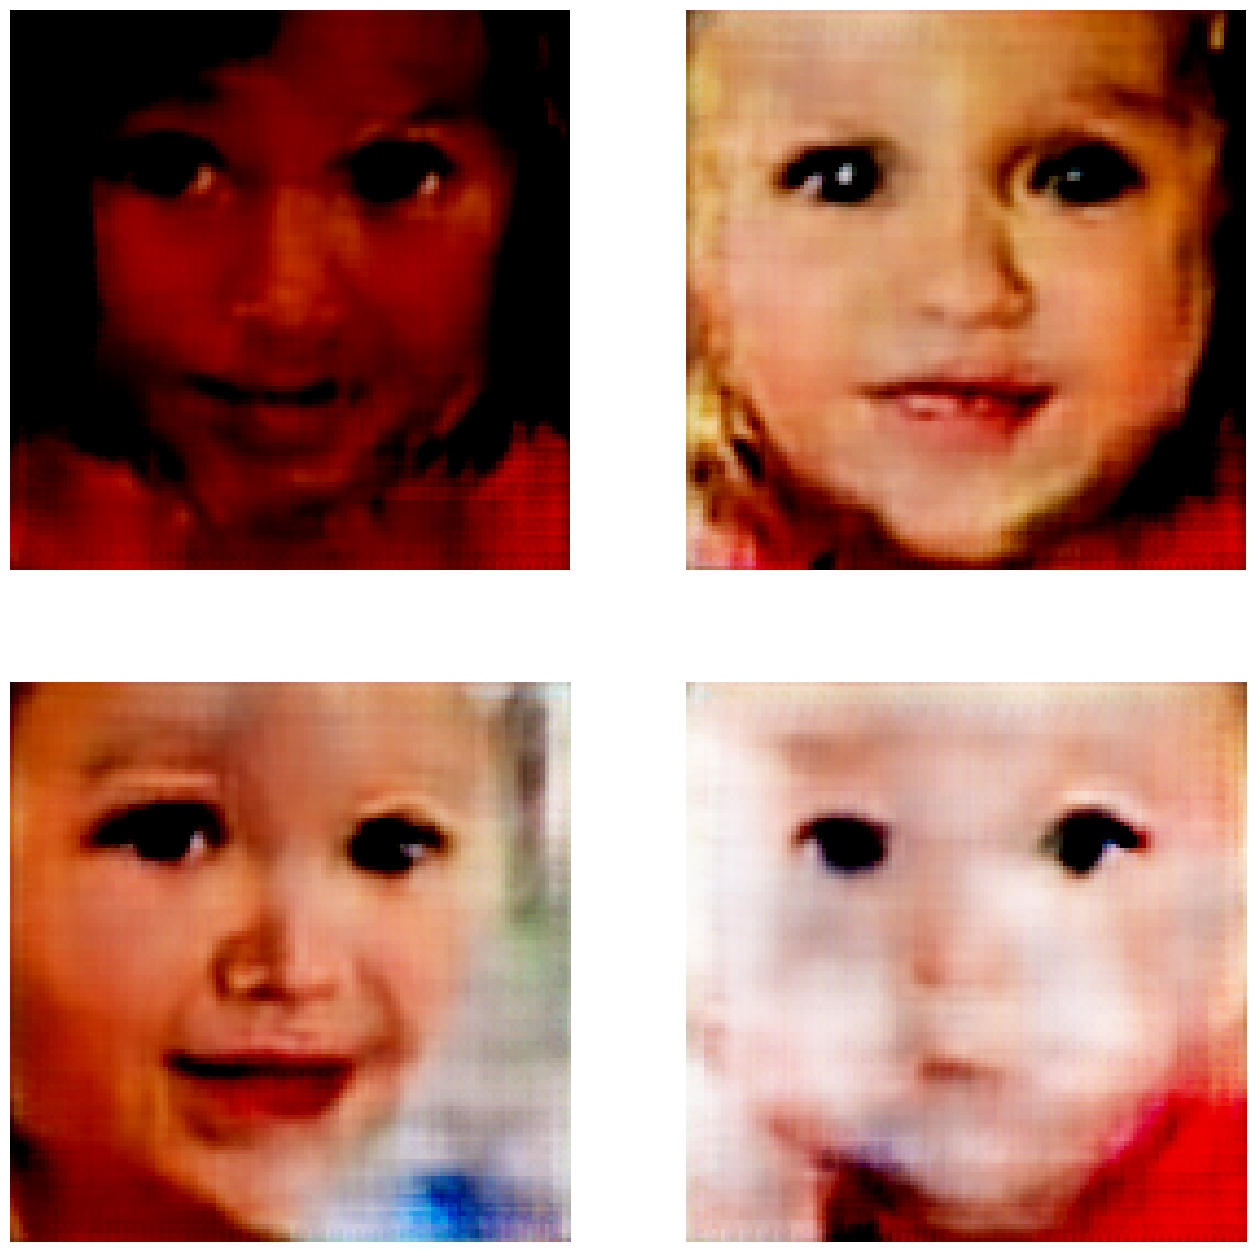

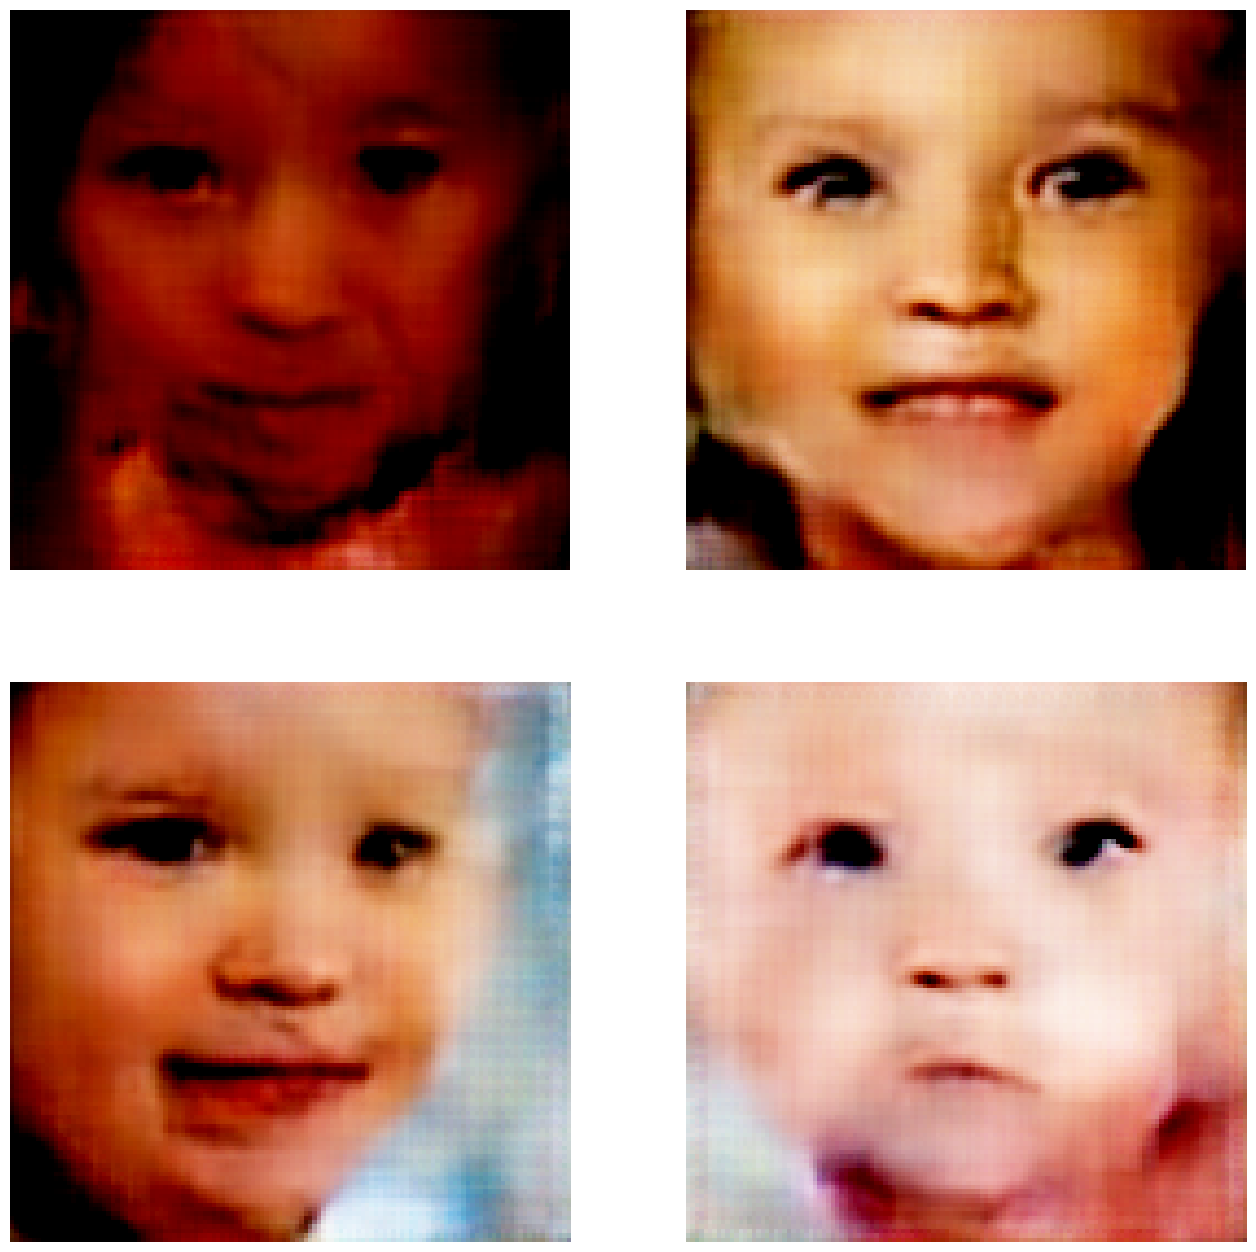

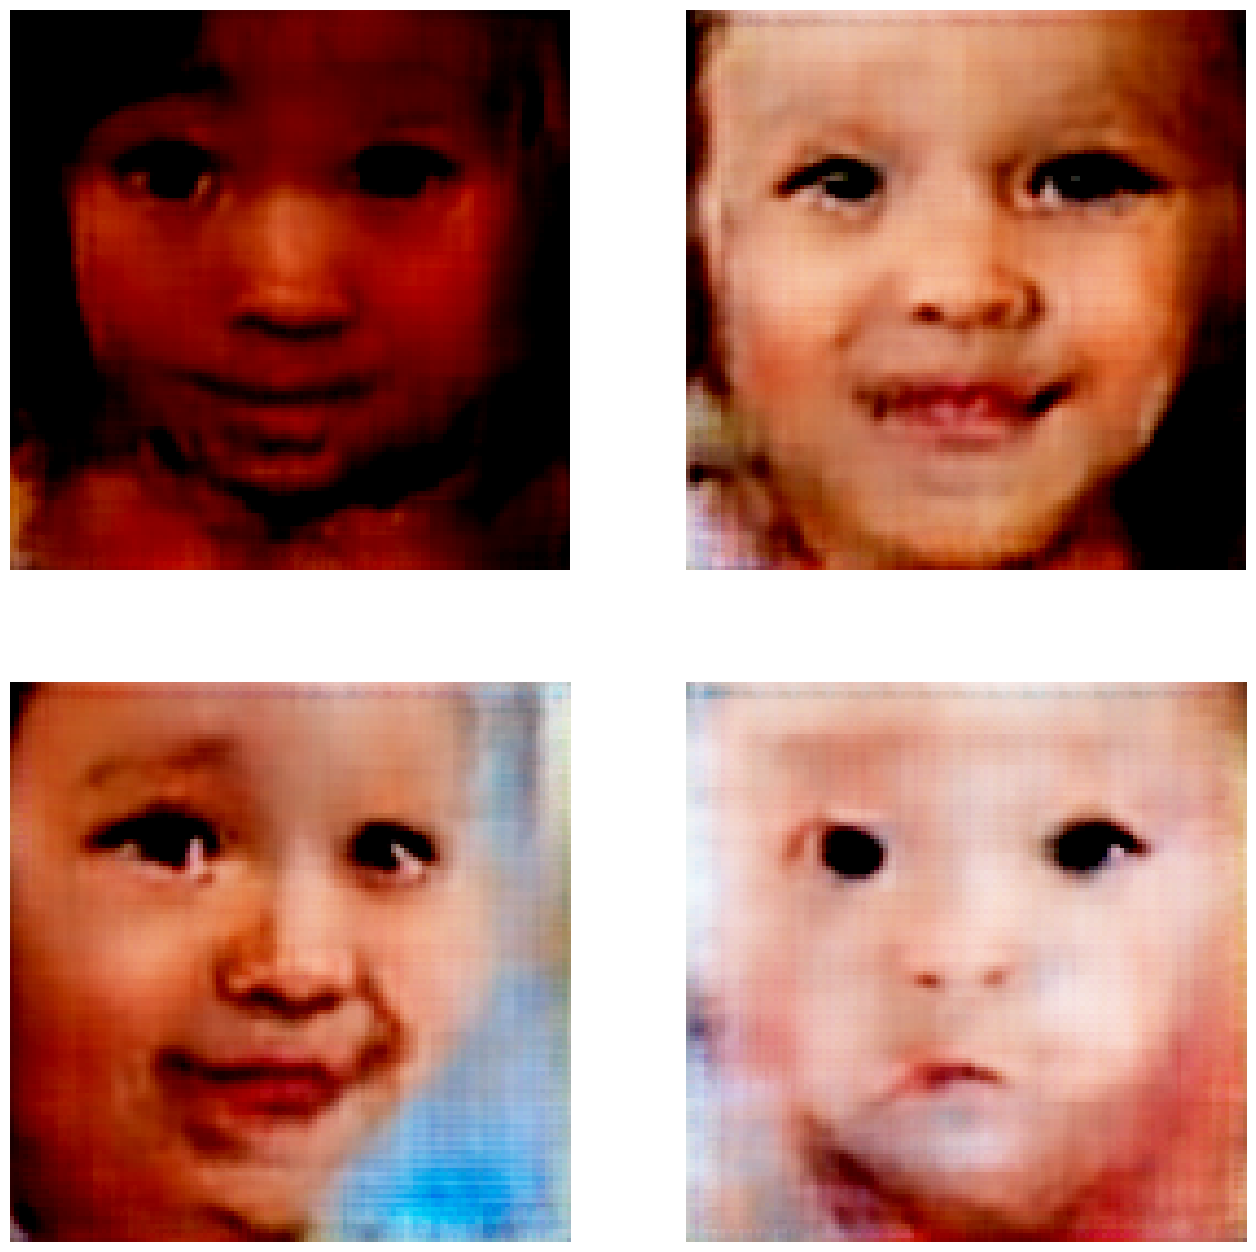

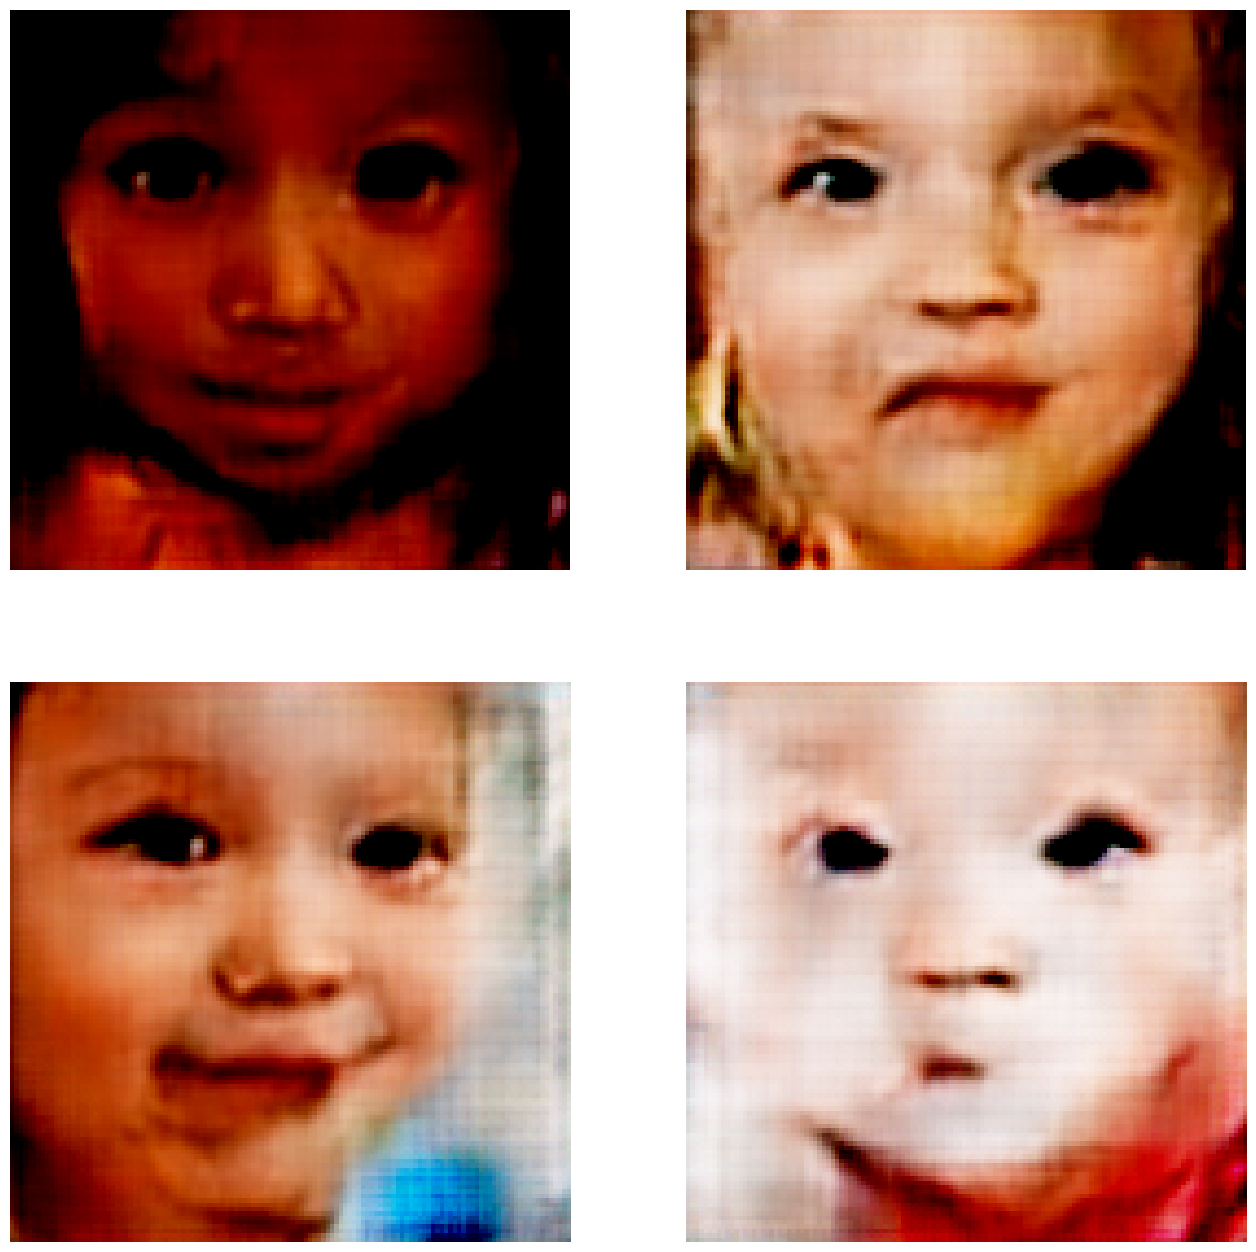

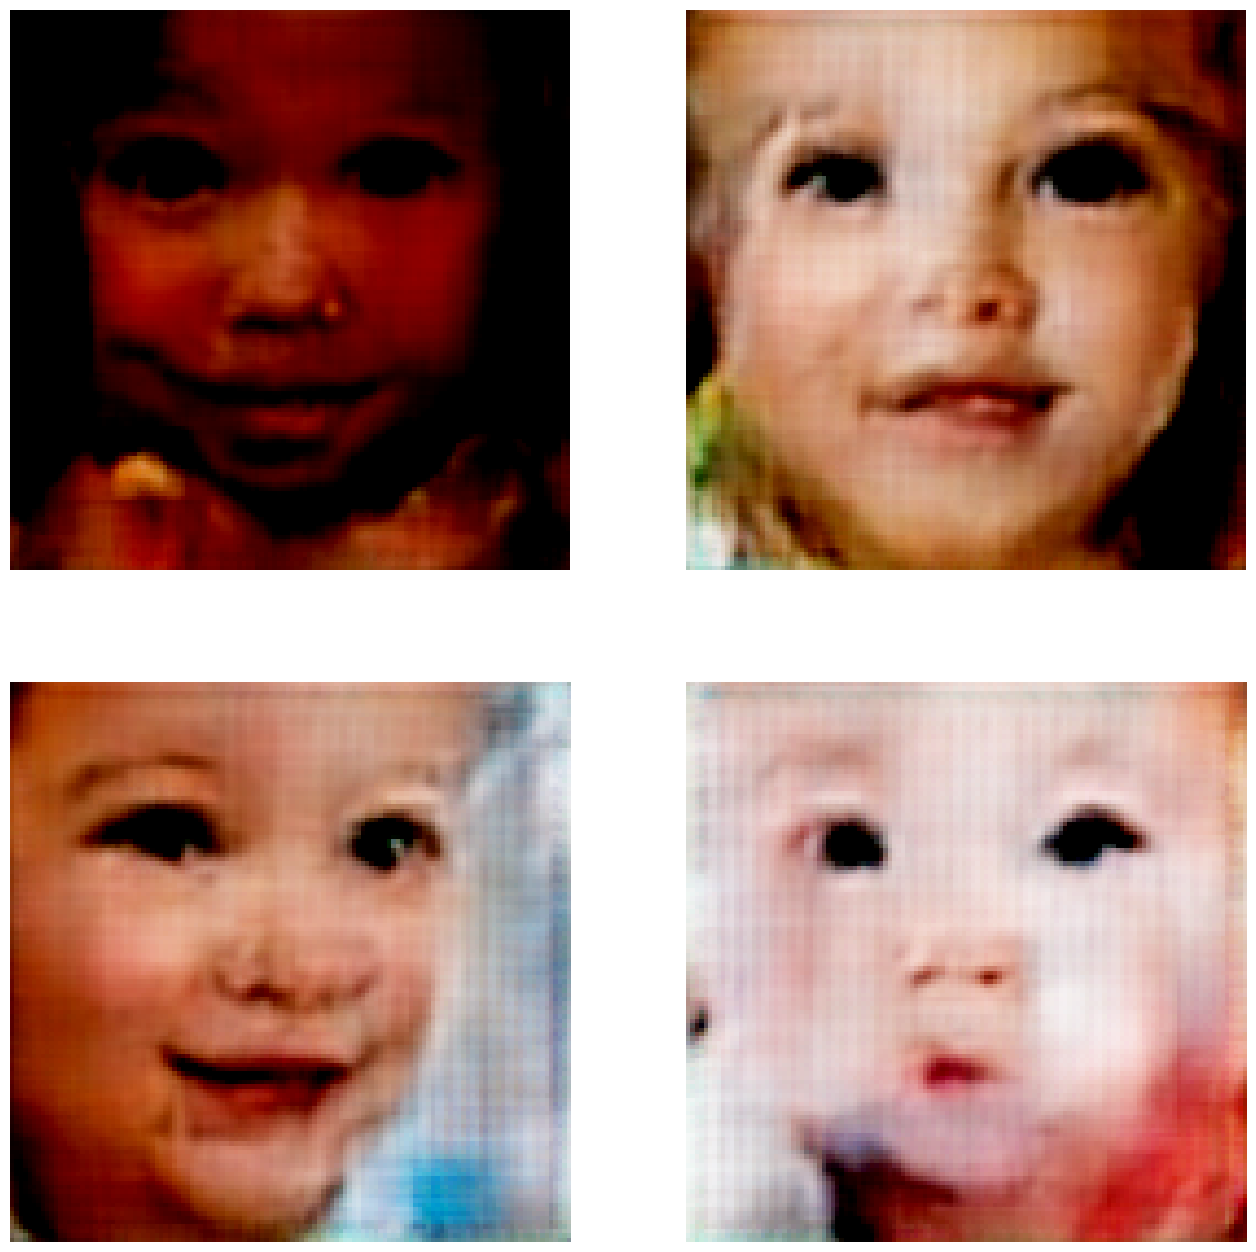

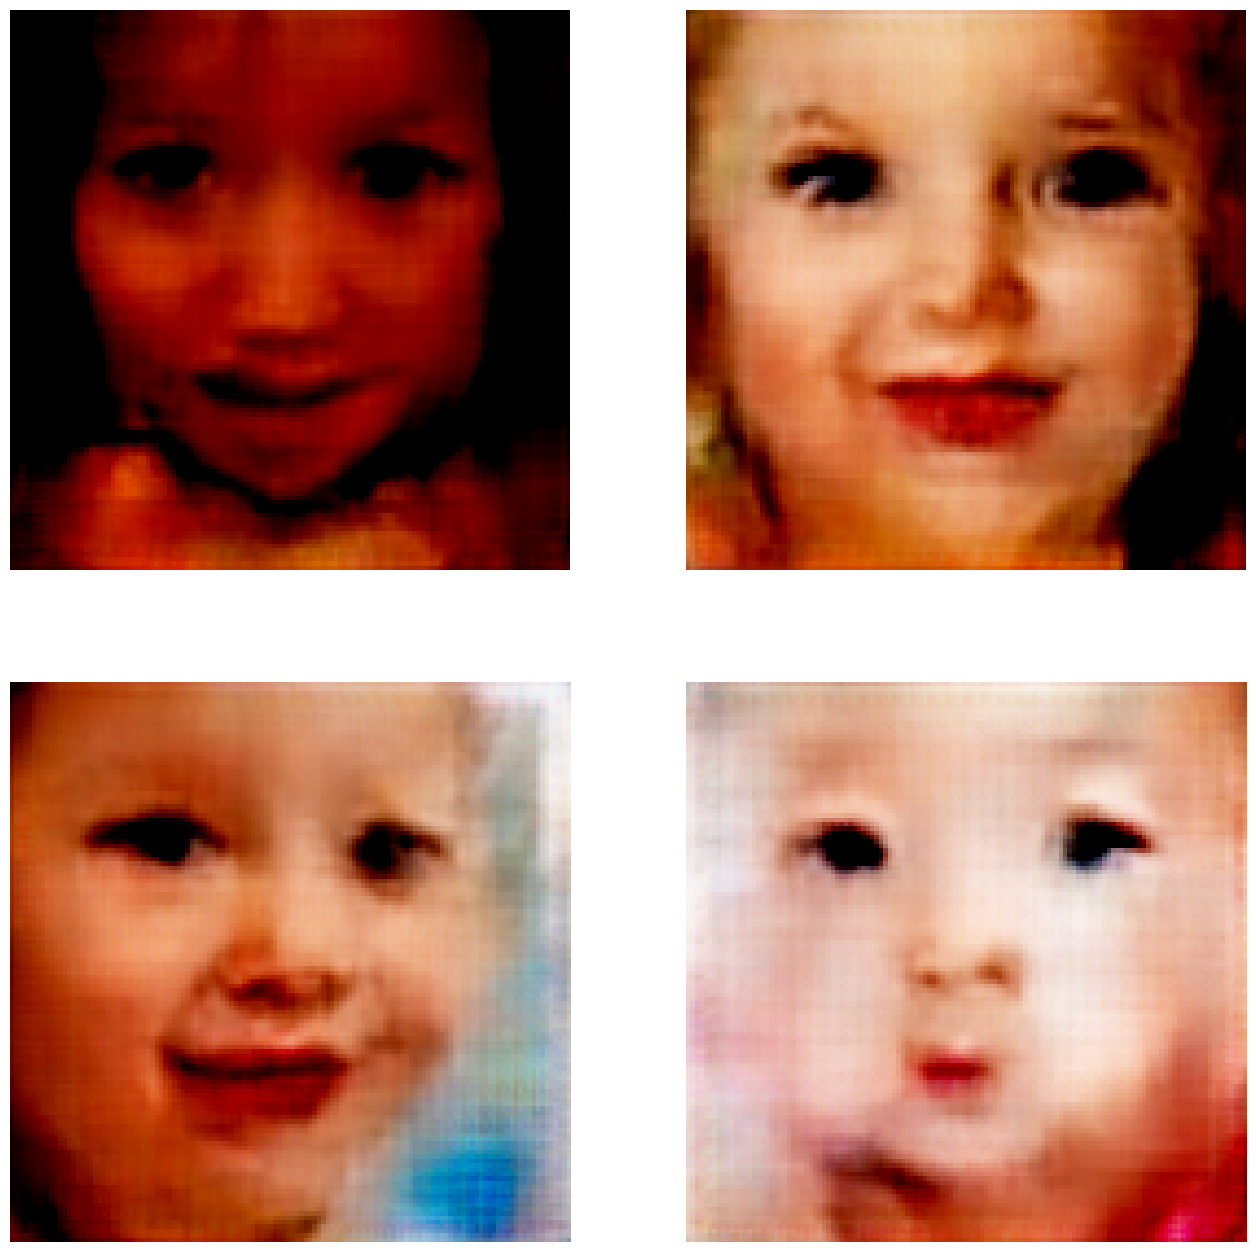

In [ ]:
cGAN.fit(train_ds, epochs=epochs, callbacks=[Generate(), Checkpoint_callback()])

In [27]:
generator.load_weights('generator.h5')
discriminator.load_weights('discriminator.h5')
encoder.load_weights('encoder.h5')

In [40]:
img = tf.io.read_file(str(image_path)+'/'+'1_0_0_20161219161028662.jpg.chip.jpg')
img = tf.io.decode_jpeg(img)
img = tf.image.resize(img, (128, 128))
img = (img-127.5)/127.5
img = tf.cast(tf.reshape(img, (128, 128, 3)), dtype=tf.float32)
img = tf.expand_dims(img, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


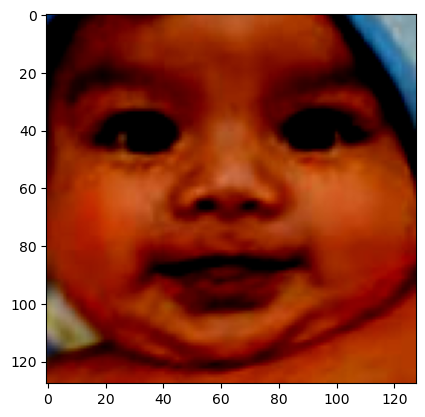

In [41]:
plt.imshow(img[0])

In [34]:
labels = to_categorical(np.array([0, 1, 2, 3, 4, 5, 6]))
#labels = (labels * 2) - 1
labels

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


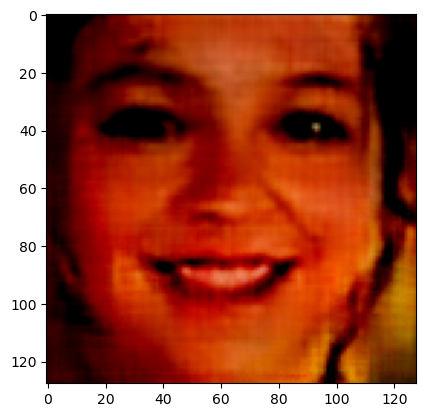

In [43]:
encoded = encoder(img)

generate = generator([encoded, np.array([labels[1]])])

plt.imshow(generate[0])